In [5]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.7 MB/s eta 0:00:0000:0100:01


In [6]:
import numpy as np
import chess
import chess.svg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from collections import deque
import random
import os
import datetime
from IPython.display import SVG, display
import json
import math
from glob import glob
from collections import defaultdict

In [7]:
pieces_order = 'KQRBNPkqrbnp'  # 12x8x8
castling_order = 'KQkq'
ind = {pieces_order[i]: i for i in range(12)}

def alg_to_coord(alg):
    rank = 8 - int(alg[1])        # 0-7
    file = ord(alg[0]) - ord('a')  # 0-7
    return rank, file


def coord_to_alg(coord):
    letter = chr(ord('a') + coord[1])
    number = str(8 - coord[0])
    return letter + number


def to_planes(fen):
    board_state = replace_tags_board(fen)
    pieces_both = np.zeros(shape=(12, 8, 8), dtype=np.float32)
    for rank in range(8):
        for file in range(8):
            v = board_state[rank * 8 + file]
            if v.isalpha():
                pieces_both[ind[v]][rank][file] = 1
    assert pieces_both.shape == (12, 8, 8)
    return pieces_both


def replace_tags_board(board_san):
    board_san = board_san.split(" ")[0]
    board_san = board_san.replace("2", "11")
    board_san = board_san.replace("3", "111")
    board_san = board_san.replace("4", "1111")
    board_san = board_san.replace("5", "11111")
    board_san = board_san.replace("6", "111111")
    board_san = board_san.replace("7", "1111111")
    board_san = board_san.replace("8", "11111111")
    return board_san.replace("/", "")


def is_black_turn(fen):
    return fen.split(" ")[1] == 'b'

def check_current_planes(realfen, planes):
    cur = planes[0:12]
    assert cur.shape == (12, 8, 8)
    fakefen = ["1"] * 64
    for i in range(12):
        for rank in range(8):
            for file in range(8):
                if cur[i][rank][file] == 1:
                    assert fakefen[rank * 8 + file] == '1'
                    fakefen[rank * 8 + file] = pieces_order[i]

    castling = planes[12:16]
    fiftymove = planes[16][0][0]
    ep = planes[17]

    castlingstring = ""
    for i in range(4):
        if castling[i][0][0] == 1:
            castlingstring += castling_order[i]

    if len(castlingstring) == 0:
        castlingstring = '-'

    epstr = "-"
    for rank in range(8):
        for file in range(8):
            if ep[rank][file] == 1:
                epstr = coord_to_alg((rank, file))

    # realfen = maybe_flip_fen(realfen, flip=is_black_turn(realfen))
    realparts = realfen.split(' ')
    assert realparts[1] == 'w'
    assert realparts[2] == castlingstring
    assert realparts[3] == epstr
    assert int(realparts[4]) == fiftymove
    # realparts[5] is the fifty-move clock, discard that
    return "".join(fakefen) == replace_tags_board(realfen)


def canon_input_planes(fen):
    """
    :param fen:
    :return : (18, 8, 8) representation of the game state
    """
    fen = maybe_flip_fen(fen, is_black_turn(fen))
    return all_input_planes(fen)


def all_input_planes(fen):
    current_aux_planes = aux_planes(fen)

    history_both = to_planes(fen)

    ret = np.vstack((history_both, current_aux_planes))
    assert ret.shape == (18, 8, 8)
    return ret


def maybe_flip_fen(fen, flip=False):
    if not flip:
        return fen
    foo = fen.split(' ')
    rows = foo[0].split('/')

    def swapcase(a):
        if a.isalpha():
            return a.lower() if a.isupper() else a.upper()
        return a

    def swapall(aa):
        return "".join([swapcase(a) for a in aa])
    return "/".join([swapall(row) for row in reversed(rows)]) \
        + " " + ('w' if foo[1] == 'b' else 'b') \
        + " " + "".join(sorted(swapall(foo[2]))) \
        + " " + foo[3] + " " + foo[4] + " " + foo[5]


def aux_planes(fen):
    foo = fen.split(' ')

    en_passant = np.zeros((8, 8), dtype=np.float32)
    if foo[3] != '-':
        eps = alg_to_coord(foo[3])
        en_passant[eps[0]][eps[1]] = 1

    fifty_move_count = int(foo[4])
    fifty_move = np.full((8, 8), fifty_move_count, dtype=np.float32)

    castling = foo[2]
    auxiliary_planes = [np.full((8, 8), int('K' in castling), dtype=np.float32),
                        np.full((8, 8), int('Q' in castling),
                                dtype=np.float32),
                        np.full((8, 8), int('k' in castling),
                                dtype=np.float32),
                        np.full((8, 8), int('q' in castling),
                                dtype=np.float32),
                        fifty_move,
                        en_passant]

    ret = np.asarray(auxiliary_planes, dtype=np.float32)
    assert ret.shape == (6, 8, 8)
    return ret

In [8]:
model_dir = 'model'
play_data_dir = 'game_data'
play_data_filename_tmpl = "play_%s.json"
# "%s.json"

def find_pgn_files(directory, pattern='*.pgn'):
  dir_pattern = os.path.join(directory, pattern)
  files = list(sorted(glob(dir_pattern)))
  return files

def read_game_data_from_file(path):
  try:
    with open(path, "rt") as f:
        return json.load(f)
  except Exception as e:
    print(e)

def get_game_data_filenames(play_data_dir,play_data_filename_tmpl):
  pattern = os.path.join(play_data_dir, play_data_filename_tmpl % "*")
  files = list(sorted(glob(pattern)))
  return files

def collect_all_loaded_data(dataset):
  """
  :return: a tuple containing the data in self.dataset, split into
  (state, policy, and value).
  """
  state_ary, policy_ary, value_ary = dataset

  state_ary1 = np.asarray(state_ary, dtype=np.float32)
  policy_ary1 = np.asarray(policy_ary, dtype=np.float32)
  value_ary1 = np.asarray(value_ary, dtype=np.float32)
  return state_ary1, policy_ary1, value_ary1

def testeval(fen, absolute=False) -> float:
    # somehow it doesn't know how to keep its queen
    piece_vals = {'K': 3, 'Q': 14, 'R': 5, 'B': 3.25, 'N': 3, 'P': 1}
    ans = 0.0
    tot = 0
    for c in fen.split(' ')[0]:
        if not c.isalpha():
            continue

        if c.isupper():
            ans += piece_vals[c]
            tot += piece_vals[c]
        else:
            ans -= piece_vals[c.upper()]
            tot += piece_vals[c.upper()]
    v = ans/tot
    if not absolute and is_black_turn(fen):
        v = -v
    assert abs(v) < 1
    return np.tanh(v * 3)  # arbitrary

def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8']
    promoted_to = ['q', 'r', 'b', 'n']

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + \
                        letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array

def flipped_uci_labels():
    """
    Seems to somehow transform the labels used for describing the universal chess interface format, putting
    them into a returned list.
    :return:
    """
    def repl(x):
        return "".join([(str(9 - int(a)) if a.isdigit() else a) for a in x])

    return [repl(x) for x in create_uci_labels()]


def flip_policy(pol):
    """
    :param pol policy to flip:
    :return: the policy, flipped (for switching between black and white it seems)
    """
    return np.asarray([pol[ind] for ind in unflipped_index])


def convert_to_cheating_data(data):
    """
    :param data: format is SelfPlayWorker.buffer
    :return:
    """
    state_list = []
    policy_list = []
    value_list = []
    for state_fen, policy, value in data:

        state_planes = canon_input_planes(state_fen)

        if is_black_turn(state_fen):
            policy = flip_policy(policy)

        move_number = int(state_fen.split(' ')[5])
        # reduces the noise of the opening... plz train faster
        value_certainty = min(10, move_number)/10
        _value = value*value_certainty + testeval(state_fen, False)*(1-value_certainty)

        state_list.append(state_planes)
        policy_list.append(policy)
        value_list.append(_value)

    return np.array(state_list, dtype=np.float32), np.array(policy_list, dtype=np.float32), np.array(value_list, dtype=np.float32)


def load_data_from_file(filename):
    data = read_game_data_from_file(filename)
    return convert_to_cheating_data(data)


labels = create_uci_labels()
n_labels = int(len(labels))
flipped_labels = flipped_uci_labels()
unflipped_index = [labels.index(x) for x in flipped_labels]
all_moves2index_dict = {move: i for i, move in enumerate(labels)}
int_to_move = {v: k for k, v in all_moves2index_dict.items()}

In [9]:
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.action_size = 8*8*73
        self.conv1 = nn.Conv2d(18, 256, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(256)

    def forward(self, s):
        s = s.view(-1, 18, 8, 8)  # batch_size x channels x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))
        return s

class ResBlock(nn.Module):
    def __init__(self, inplanes=256, planes=256, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out

class OutBlock(nn.Module):
    def __init__(self):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 4, kernel_size=1) # value head
        self.bn = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(8*8*4, 256)
        self.fc2 = nn.Linear(256, 1)

        self.conv1 = nn.Conv2d(256, 2, kernel_size=1) # policy head
        self.bn1 = nn.BatchNorm2d(2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.fc = nn.Linear(8*8*2, 1968)

    def forward(self, s):
        v = F.relu(self.bn(self.conv(s))) # value head
        v = v.view(-1, 4*8*8)
        v = F.relu(self.fc1(v))
        v = F.tanh(self.fc2(v))

        p = F.relu(self.bn1(self.conv1(s))) # policy head
        p = p.view(-1, 2*8*8)
        p = self.fc(p)
        p = self.logsoftmax(p).exp()
        return p, v

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv = ConvBlock()
        self.depth = 19
        for block in range(self.depth):
            setattr(self, f"res_{block}", ResBlock())
        self.outblock = OutBlock()

    def forward(self, s):
        s = self.conv(s)
        for block in range(self.depth):
            s = getattr(self, f"res_{block}")(s)
        return self.outblock(s)

In [10]:
class GameState(chess.Board):
    def __init__(self, fen=None):
        """
        初始化 GameState，默認使用標準起始局面。
        Args:
            fen (str, optional): 用於初始化的 FEN 字符串。
        """
        super().__init__(fen)

    def get_legal_actions(self):
        """
        獲取當前局面下的所有合法動作。
        Returns:
            list[chess.Move]: 一個包含所有合法行棋的列表。
        """
        return list(self.legal_moves)

    def copy_and_apply(self, action):
        """
        創建當前局面的副本，並應用指定的動作。
        Args:
            action (chess.Move): 要執行的動作。
        Returns:
            GameState: 更新後的新局面。
        """
        new_state = GameState(self.fen())
        new_state.push(action)
        return new_state

    def is_game_over(self):
        """
        判斷遊戲是否結束。
        Returns:
            bool: 如果遊戲結束則返回 True，否則 False。
        """
        return super().is_game_over()

    def get_result(self):
        """
        獲取當前局面的結果。
        Returns:
            float: 
                - 1.0: 白方勝利
                - -1.0: 黑方勝利
                - 0.0: 平局
        """
        if self.is_checkmate():
            return 1.0 if self.turn == chess.BLACK else -1.0
        # elif self.is_stalemate() or self.is_insufficient_material():
        #     return 0.0
        else:
            return 0.0
        return None  # 遊戲尚未結束

    def fen(self):
        """
        返回當前局面的 FEN 表示。
        Returns:
            str: FEN 字符串。
        """
        return super().fen()

    def tensor(self):
        return torch.FloatTensor(np.array(canon_input_planes(self.fen()))).unsqueeze(0).to(device)

    def is_black_turn(self):
        return self.fen().split(" ")[1] == 'b'


In [24]:
class Node:
    def __init__(self, state, config=config):
        self.config = config
        self.state = state             # 棋局狀態 (GameState)
        self.children = {}             # 子節點: {action: Node}
        self.visits = 0                # 節點被訪問次數 N(s)
        self.total_value = 0           # 總回報值 W(s)
        self.policy = None             # 策略分佈 P(s, a)

    def is_leaf(self):
        return len(self.children) == 0

    def expand(self, policy, prune_threshold=0.01):
        """
        擴展節點，基於策略 P(s, a) 和全域 index_to_action 進行剪枝。
        Args:
            policy (list): 動作機率陣列，index 對應到全域變數 index_to_action。
            prune_threshold (float): 剪枝閾值，低於該值的動作將被忽略。
        """
        # self.policy = {
        #     chess.Move.from_uci(self.config.labels[i]): p for i, p in enumerate(policy) if p >= prune_threshold
        # }
        self.policy = {chess.Move.from_uci(
            self.config.labels[i]): p for i, p in enumerate(policy)
        }
        for action in self.state.get_legal_actions():
            if action in self.policy.keys():
                new_state = self.state.copy_and_apply(action)
                self.children[action] = Node(new_state)

    def select_child(self, c_puct=1.0):
        """
        使用 PUCT 演算法選擇子節點。
        Args:
            c_puct (float): 探索與利用的權衡參數。
        Returns:
            (action, Node): 最佳動作及其對應子節點。
        """
        total_visits = sum(child.visits for child in self.children.values())
        best_score, best_action, best_node = -float('inf'), None, None

        for action, child in self.children.items():
            q = (-1) * child.total_value / (child.visits + 1e-6)  # 避免除以 0 # 下個點的total value是反的
            u = c_puct * self.policy[action] * \
                math.sqrt(total_visits) / (1 + child.visits)
            score = q + u
            if score > best_score:
                best_score, best_action, best_node = score, action, child

        return best_action, best_node

    def update(self, value):
        """
        更新節點的訪問次數和回報值。
        Args:
            value (float): 當前模擬的回傳值。
        """
        self.visits += 1
        self.total_value += value

    def best_action(self, temperature=1):
        """
        根據訪問次數 N(s, a) 選擇最佳行棋，支持隨機性。
        Args:
            temperature (float): 控制隨機性的參數，越接近 0 越貪婪。
        Returns:
            action: 根據隨機性或最大訪問次數選出的行棋。
        """
        visits = np.array([child.visits for child in self.children.values()])
        actions = list(self.children.keys())

        if temperature == 0:  # 純貪婪策略
            return actions[np.argmax(visits)]

        # 應用溫度進行概率調整
        probabilities = visits ** (1 / temperature)
        probabilities /= probabilities.sum()
        if len(actions) == 0:
            return None
        
        policy = self.get_policy(actions,probabilities)

        # 隨機抽樣
        return np.random.choice(actions, p=probabilities),policy
    
    def get_policy(self,actions,probabilities):
        policy = np.zeros((self.config.n_labels))
        for action,p in zip(actions,probabilities):
            ind = self.config.all_moves2index_dict[action.uci()]
            policy[ind] = p
        return list(policy)


class MCTS:
    def __init__(self, model, max_depth=15, config=None):
        """
        初始化 MCTS。
        Args:
            get_model_p_v (function): 獲取策略 (policy) 和價值 (value) 的神經網路函數。
            max_depth (int): 每次模擬的最大深度。
        """
        self.model = model
        self.max_depth = max_depth
        self.config = config if config else Config()

    def search(self, root_state, n_simulations):
        """
        執行 MCTS 搜索。
        Args:
            root_state (chess.Board): 初始遊戲狀態。
            n_simulations (int): 模擬次數。
        Returns:
            Node: MCTS 搜索後的根節點。
        """
        root = Node(GameState(root_state.fen()))

        for _ in range(n_simulations):
            node = root
            path = []
            depth = 0

            # Selection
            while not node.is_leaf() and depth < self.max_depth:
                action, node = node.select_child()
                path.append(node)
                depth += 1

            # Expansion
            if not node.state.is_game_over() and depth < self.max_depth:
                policy, value = self.model(node.state.tensor())
                policy = policy.squeeze(0).detach().cpu().numpy()
                value = value.squeeze(0).detach().cpu().numpy()
                if node.state.is_black_turn():
                    policy = self.config.flip_policy(policy)
                node.expand(policy)
            else:
                # 如果遊戲結束或達到模擬深度，直接返回當前值
                if node.state.is_game_over():
                    value = node.state.get_result()
                    # flip value
                    if node.state.is_black_turn():
                        value = -value
                else:
                    policy, value = self.model(node.state.tensor())
                    # policy = policy.squeeze(0).detach().cpu().numpy()
                    value = value.squeeze(0).detach().cpu().numpy()
                    # if is_black_turn(node.state.fen()):
                    #     policy = flip_policy(policy)

            # Backpropagation
            for ancestor in reversed(path):
                ancestor.update(value)
                value = -value  # 翻轉值，因對手的收益是自己的損失

        return root

NameError: name 'config' is not defined

In [33]:
class ChessAgent:
    def __init__(self, name, device, path=None):
        self.name = name
        self.device = device
        self.model = ChessNet().to(device)
        model_dir = 'model'

        if path:
          self.load_model(model_dir,path)
          self.model.to(device)
        else:
          pass

    def load_model(self, dir, filename):
        """Load a model from disk."""
        if os.path.exists(os.path.join(dir,filename)):
            # save_data = torch.load(os.path.join(dir,filename))
            save_data = torch.load(os.path.join(dir,filename),map_location=self.device)
            self.model.load_state_dict(save_data)
            print(f"Model loaded from {filename}")
            return True
        return False

    def save_model(self,dir, filename):
        """Save a model to disk."""
        save_data = {
            'model_state': self.model.state_dict()
        }
        path = os.path.join(dir,filename)
        torch.save(save_data, path)
        print(f"Model saved to {path}")

    def choose_action(self, board,max_depth = 15,n_simulations=500,mode = 'mcts',temperature=0):
        """Choose action by probability."""
        if mode == 'mcts':
            tree = MCTS(self.model, max_depth=max_depth)
            root = tree.search(board, n_simulations=n_simulations)
            move = root.best_action(temperature = temperature)
            if move is None:
                print('Warning!!!!!you model is not working in this situation.')
                move = random.choice(list(board.legal_moves))
            return move.uci()


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_model_name = ''
pattern = os.path.join('./model', 'train_%s' % "*")
init_model_name = list(sorted(glob(pattern)))[-1].split('/')[-1]
print(f'best model:{init_model_name}')
agent = ChessAgent(name='w',device=device,path=init_model_name)
# agent = ChessAgent("white",device,model_path)

best model:train_050314440200.pt
Model loaded from train_050314440200.pt


In [35]:
summary(agent.model,(18,8,8),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 256, 8, 8]         115,456
       BatchNorm2d-2            [-1, 256, 8, 8]             512
         ConvBlock-3            [-1, 256, 8, 8]               0
            Conv2d-4            [-1, 256, 8, 8]         589,824
       BatchNorm2d-5            [-1, 256, 8, 8]             512
            Conv2d-6            [-1, 256, 8, 8]         589,824
       BatchNorm2d-7            [-1, 256, 8, 8]             512
          ResBlock-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         589,824
      BatchNorm2d-10            [-1, 256, 8, 8]             512
           Conv2d-11            [-1, 256, 8, 8]         589,824
      BatchNorm2d-12            [-1, 256, 8, 8]             512
         ResBlock-13            [-1, 256, 8, 8]               0
           Conv2d-14            [-1, 25

In [36]:
print(agent.model.parameters)

<bound method Module.parameters of ChessNet(
  (conv): ConvBlock(
    (conv1): Conv2d(18, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_0): ResBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_1): ResBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [37]:
board = chess.Board('rq5r/1pp1k1pp/4bp2/p2pp3/3nPP2/6PP/K7/5BNR b - - 2 24')
# board.push(chess.Move.from_uci('e2e4'))
# board.push(chess.Move.from_uci('e7e5'))
state = GameState(board.fen())
policy, value = agent.model(state.tensor())
print(value)

tensor([[-0.0014]], device='cuda:0', grad_fn=<TanhBackward0>)


In [38]:
class SelfPlayer:
    def __init__(self,white_model_path=None,black_model_path=None):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.white_agent = ChessAgent("white", self.device,white_model_path)
        self.black_agent = ChessAgent("black", self.device,black_model_path)
        self.board = chess.Board()
        self.memory = []

    def save_to_file(self,output_dir='game_data'):
        """將資料集儲存到 JSON 文件"""
        num = len(self.memory)
        D = datetime.datetime.today()
        if self.memory:
            file_path = os.path.join(output_dir, f"self_play_dataset_{D.month}{D.day}{D.hour}{D.minute}{D.second}.json")
            with open(file_path, "w") as f:
                json.dump(self.memory, f, indent=4)
            print(f"Saved {num} records to {file_path}")
            self.memory = []


    def play_games(self,games = 1000,max_data_len = 100000):
      """Play a game between the two agents and collect training data."""
      for _ in range(games):
        self.board.reset()
        game_memory = []
        current_agent = self.white_agent

        while not self.board.is_game_over():
            state = self.board.copy()

            move = current_agent.choose_action(self.board,n_simulations=500,max_depth=10)

            self.board.push(chess.Move.from_uci(move))

            # The value target will be updated after the game ends
            game_memory.append((state.fen(), move, current_agent))
            current_agent = self.black_agent if current_agent == self.white_agent else self.white_agent

        # Determine game outcome
        if self.board.is_checkmate():
            value = 1 if self.board.turn == chess.BLACK else -1
        else:  # Draw
            value = 0

        # Update memories with correct values
        for state, policy, agent in game_memory:
            self.memory.append((state, policy, value))
            value = -value  # Flip value for opponent
        if len(self.memory) >= max_data_len:
            self.save_to_file()
      self.save_to_file()
        
      return value
    
    def test(self):
        self.board.reset()
        import time
        current_agent = self.white_agent
        while not self.board.is_game_over():
            move = current_agent.choose_action(self.board)

            self.board.push(chess.Move.from_uci(move))
            display(self.board)
            time.sleep(1)
            current_agent = self.black_agent if current_agent == self.white_agent else self.white_agent
        return self.board

In [39]:
selfplayer = SelfPlayer(white_model_path=init_model_name,black_model_path=init_model_name)

Model loaded from train_050314440200.pt
Model loaded from train_050314440200.pt


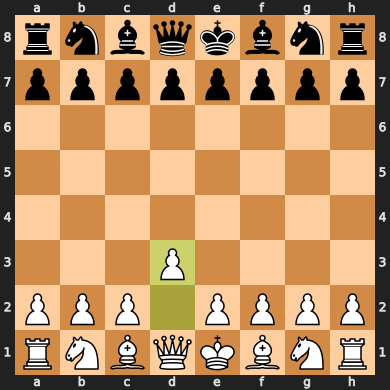

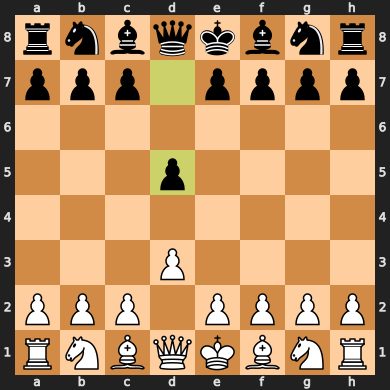

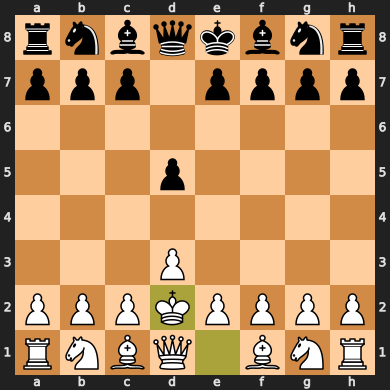

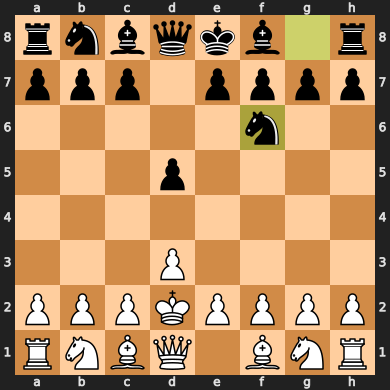

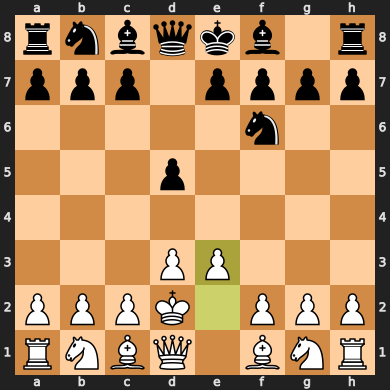

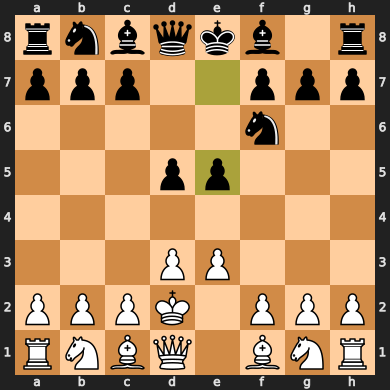

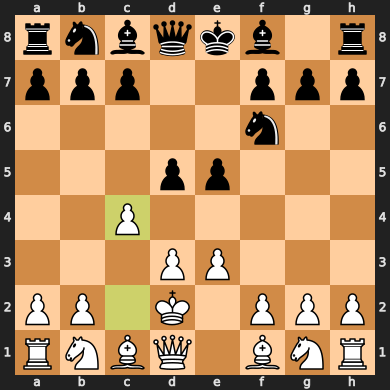

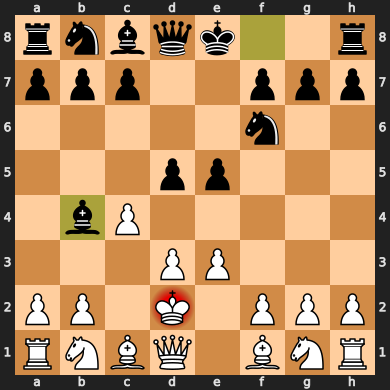

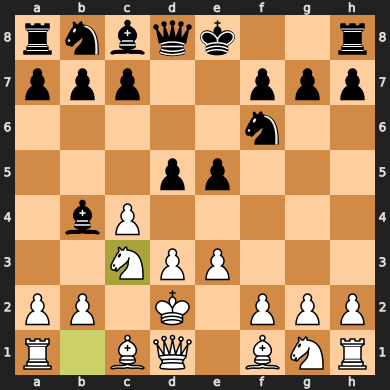

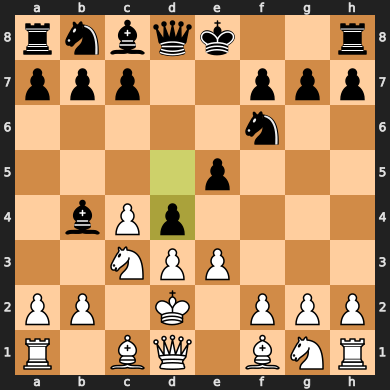

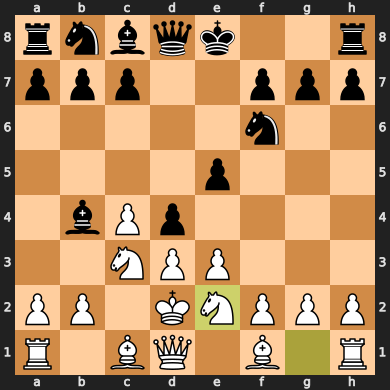

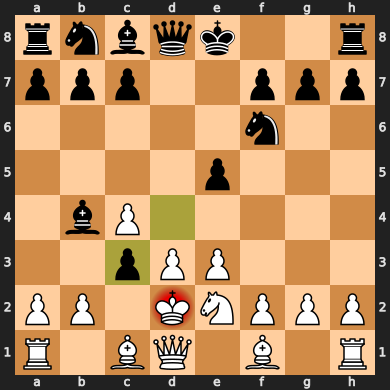

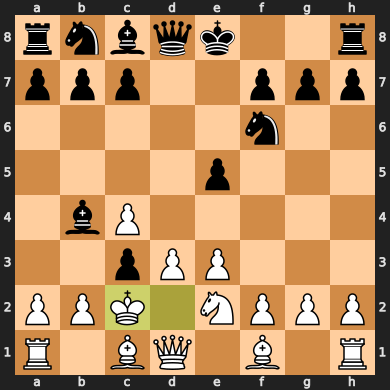

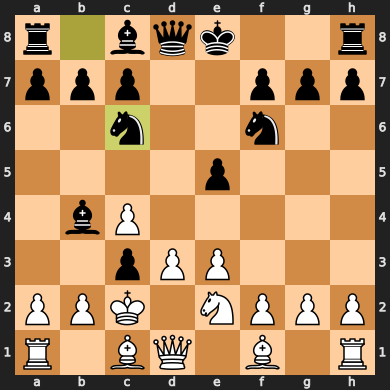

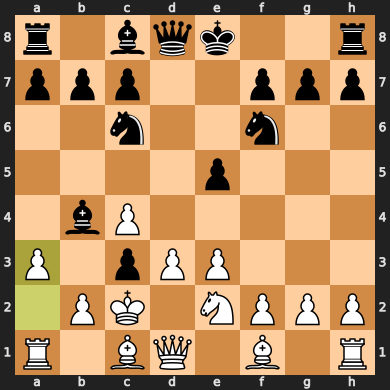

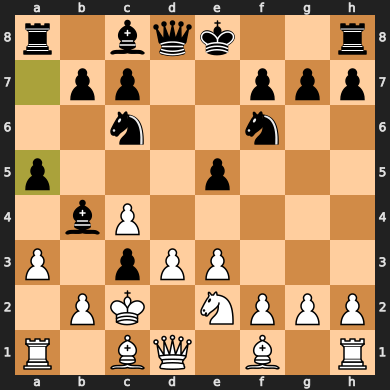

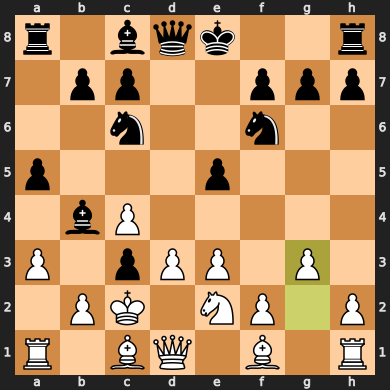

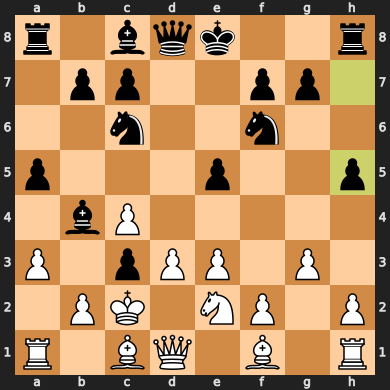

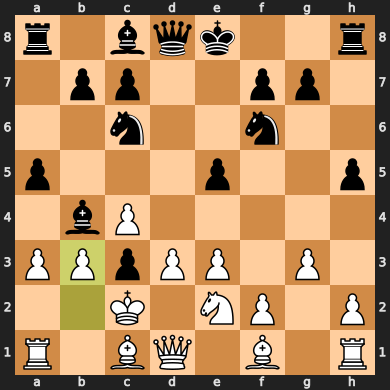

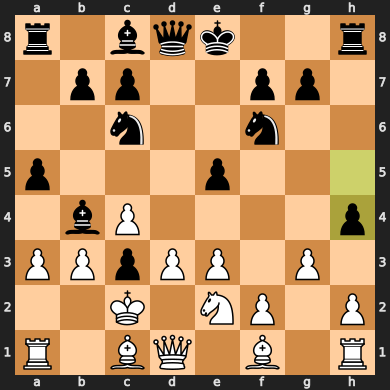

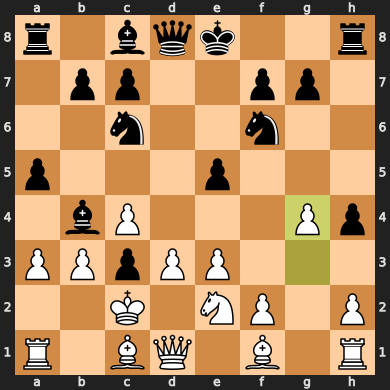

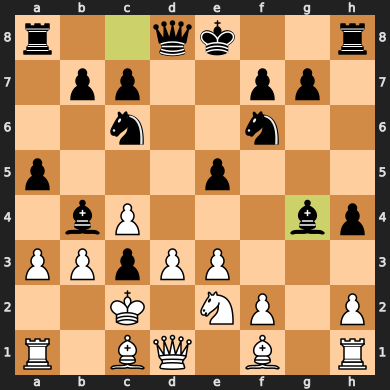

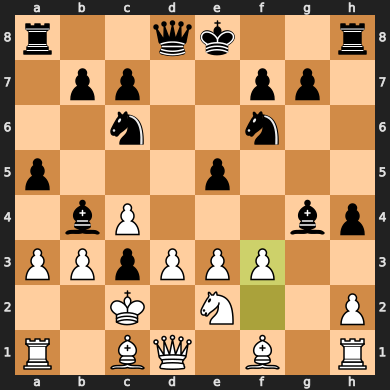

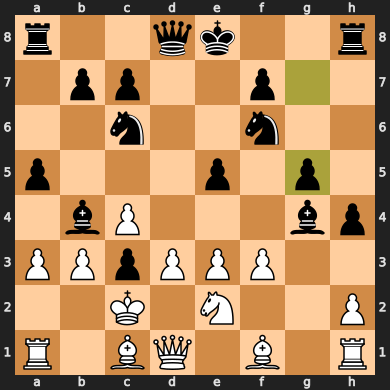

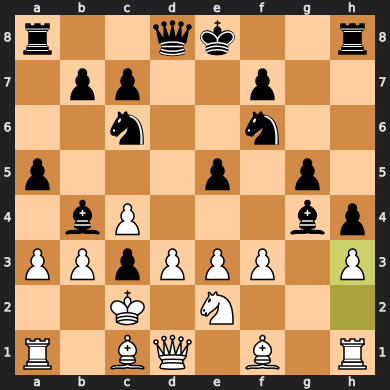

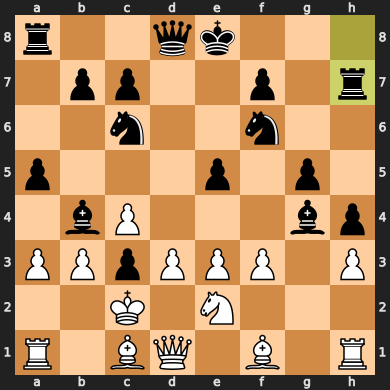

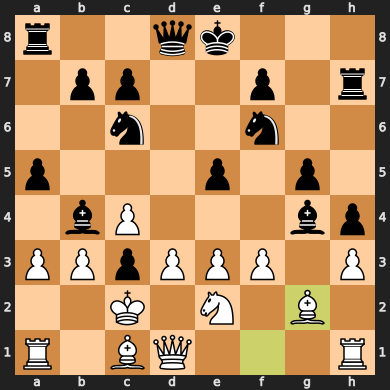

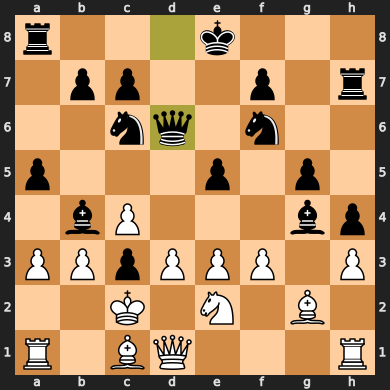

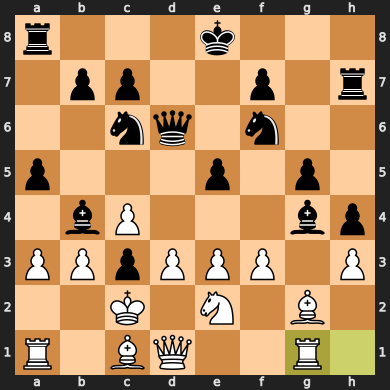

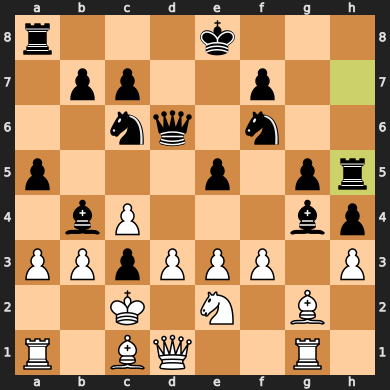

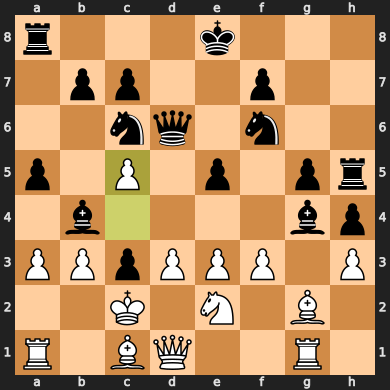

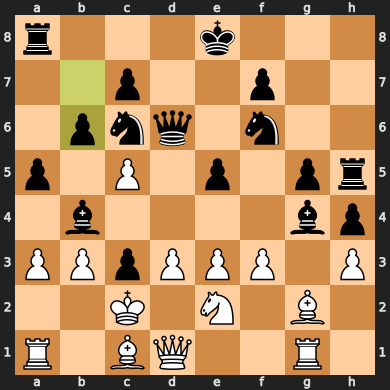

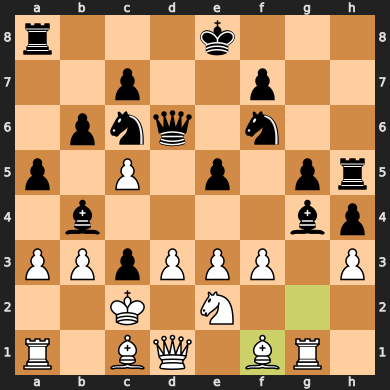

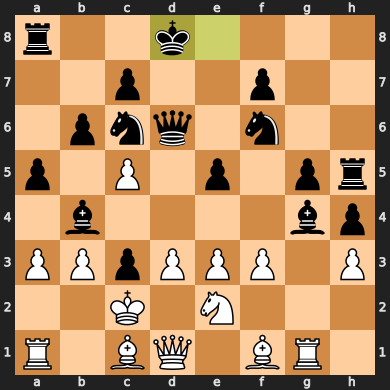

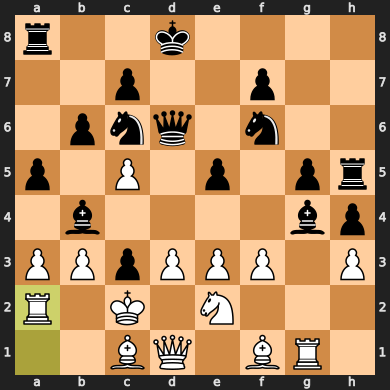

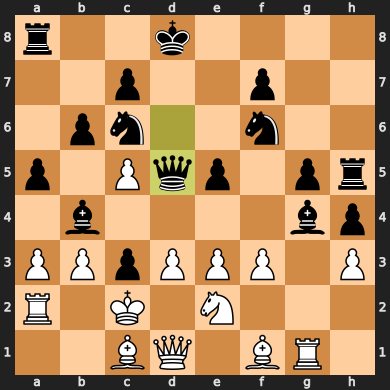

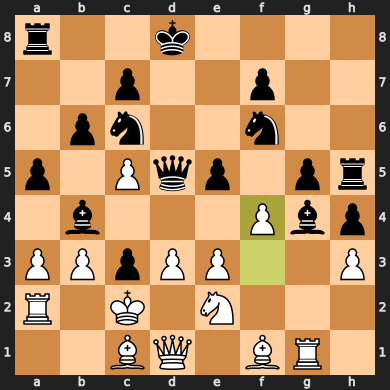

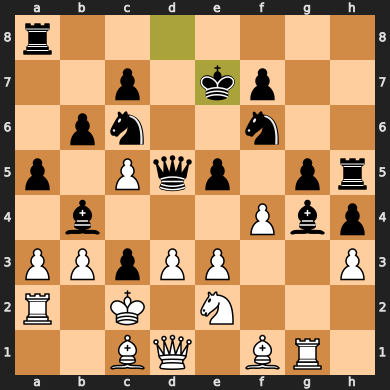

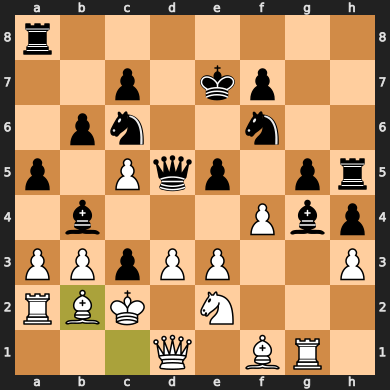

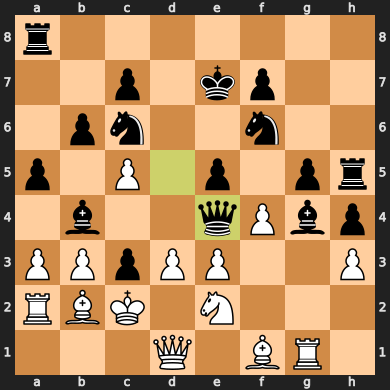

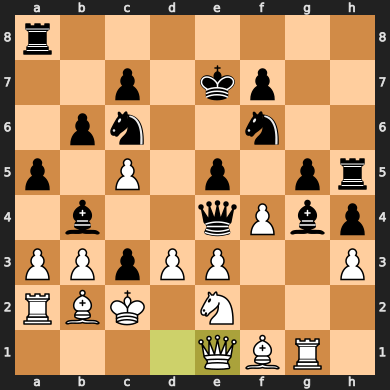

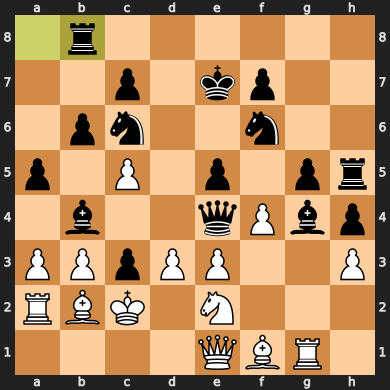

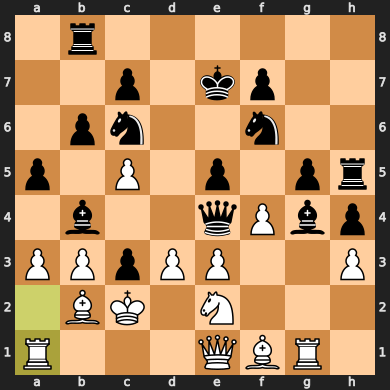

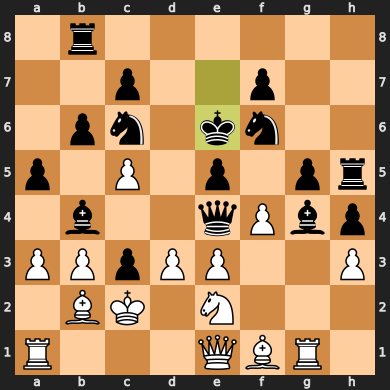

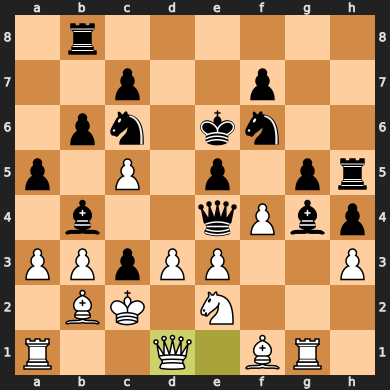

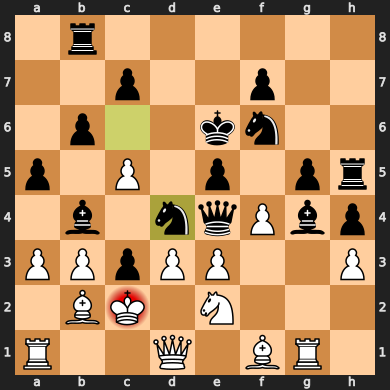

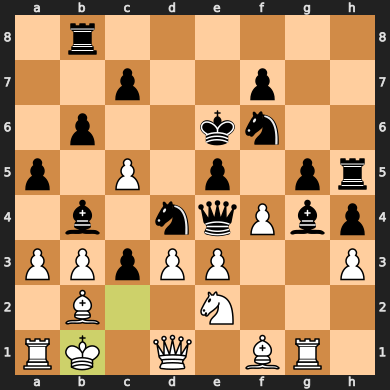

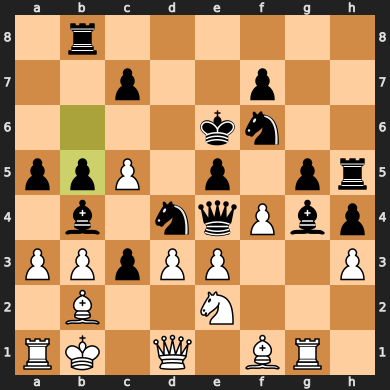

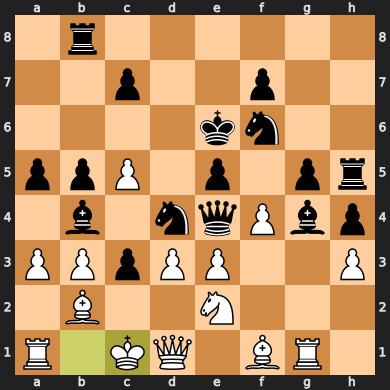

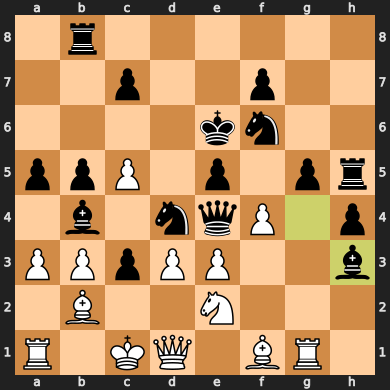

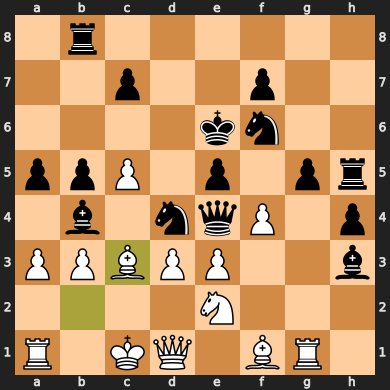

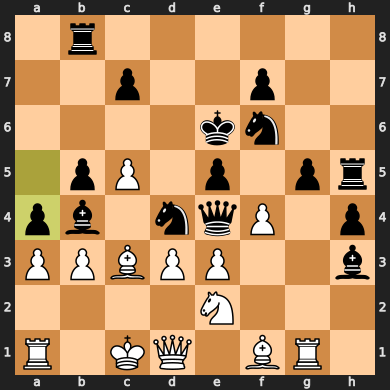

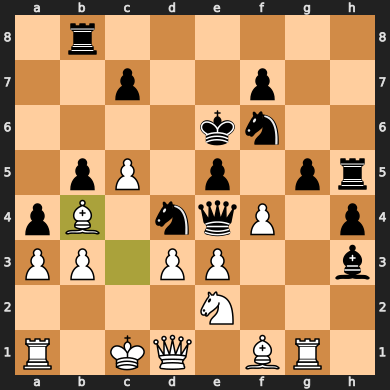

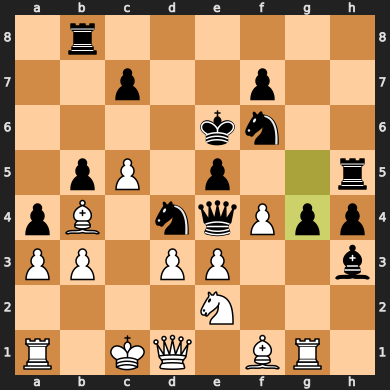

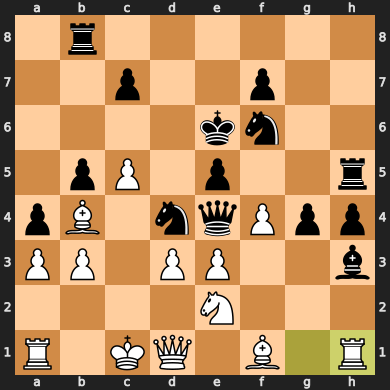

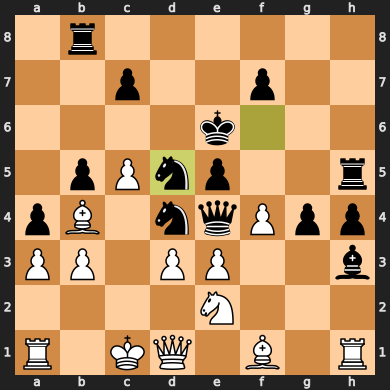

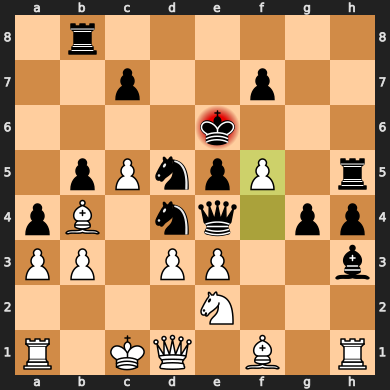

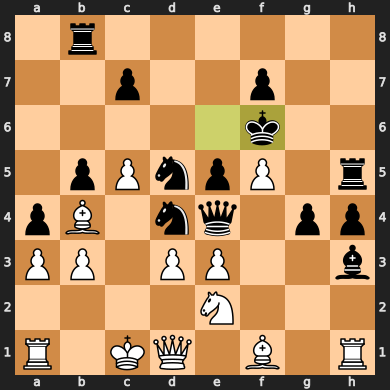

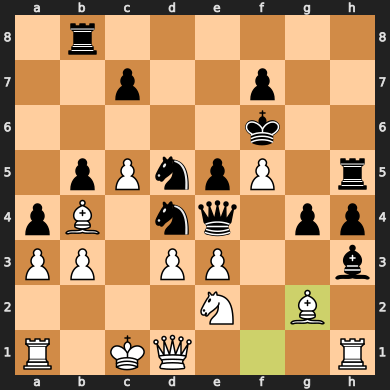

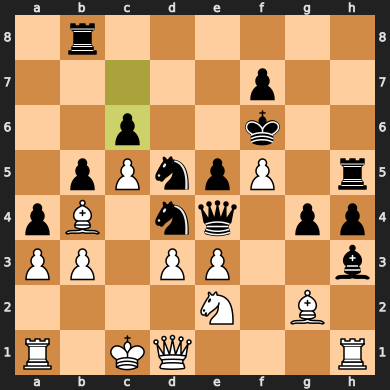

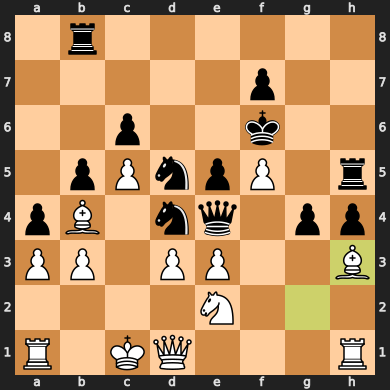

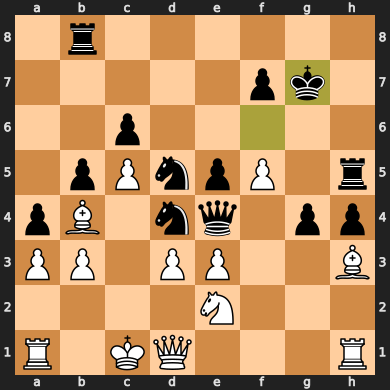

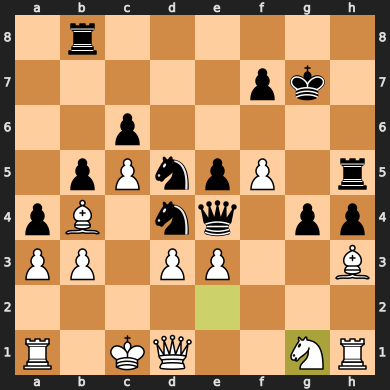

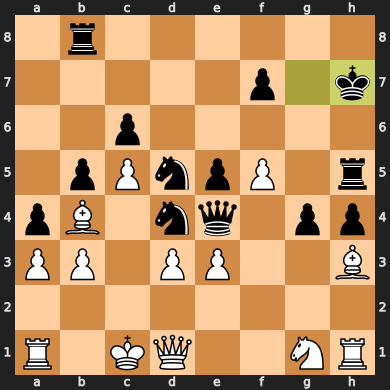

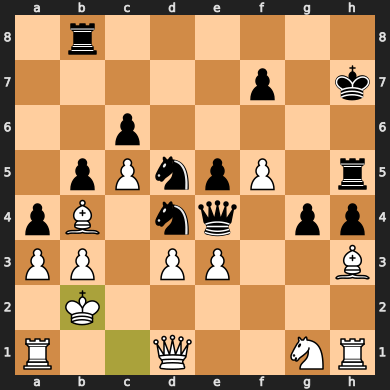

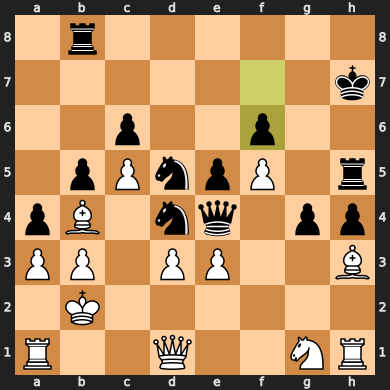

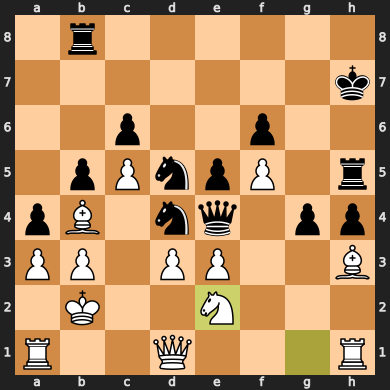

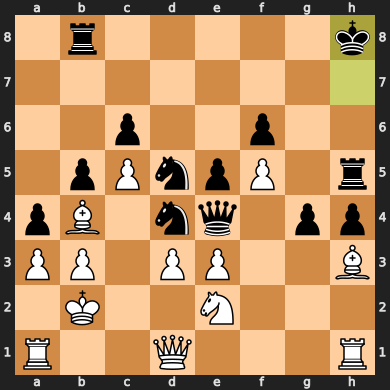

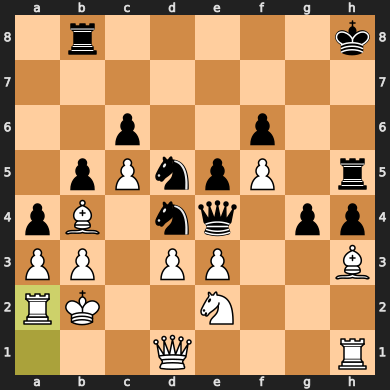

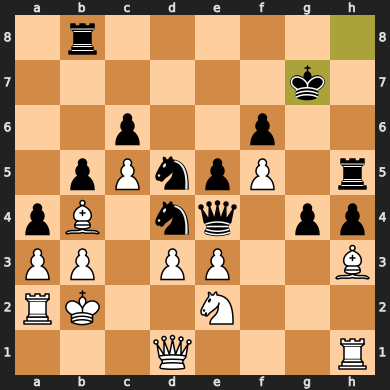

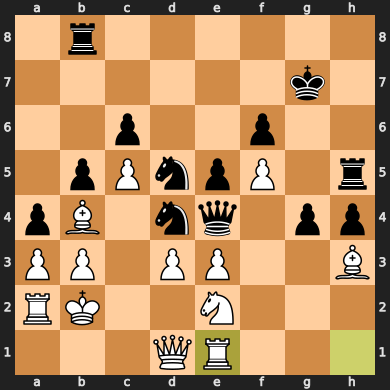

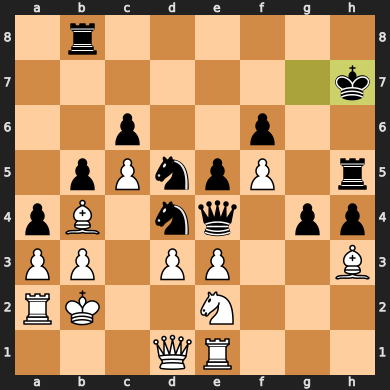

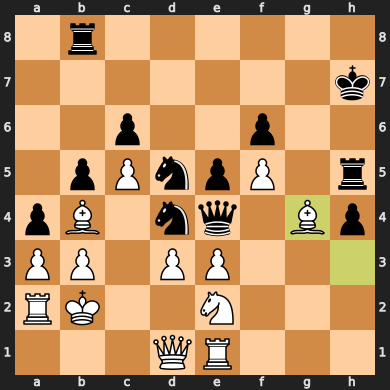

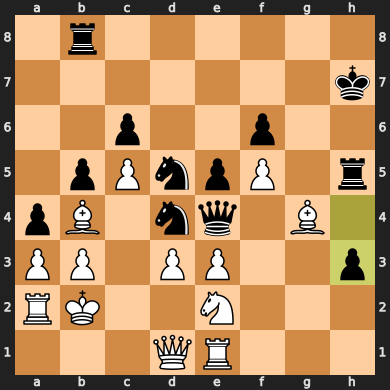

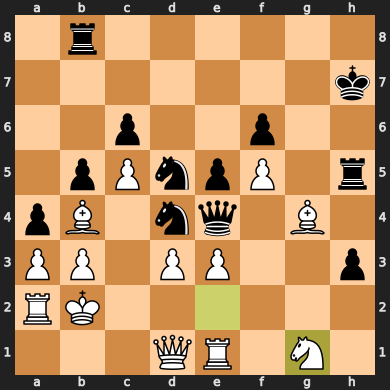

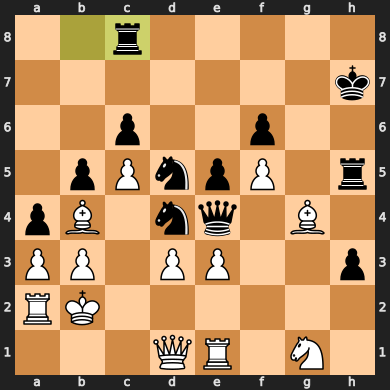

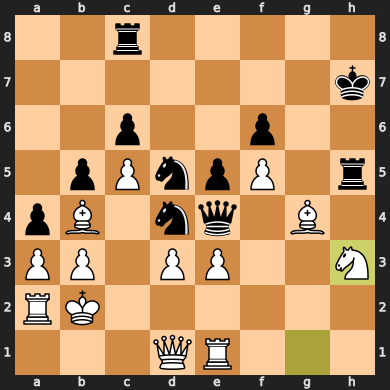

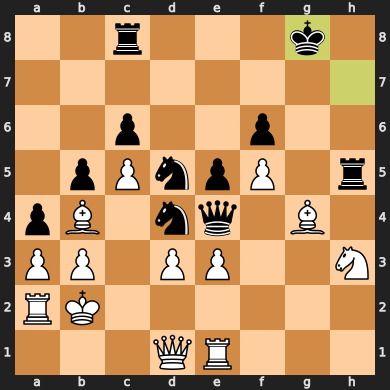

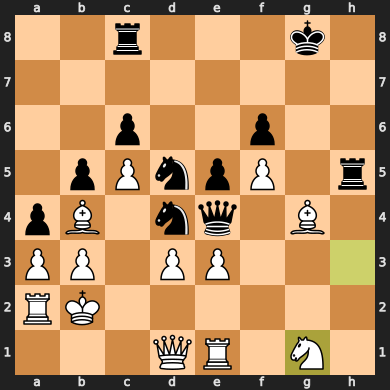

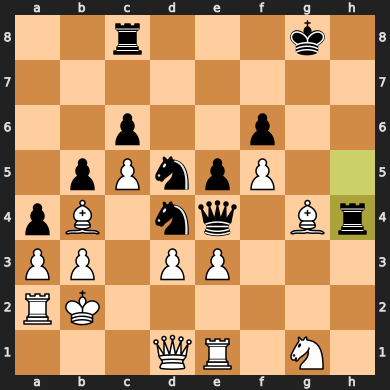

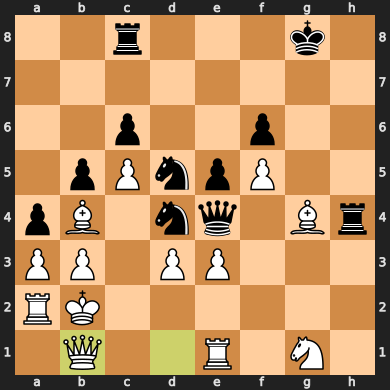

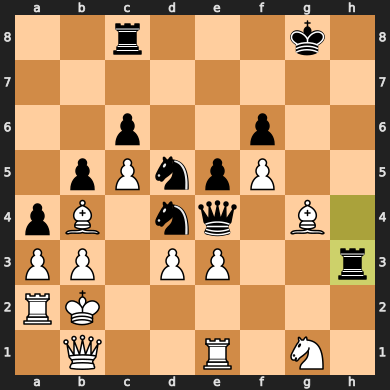

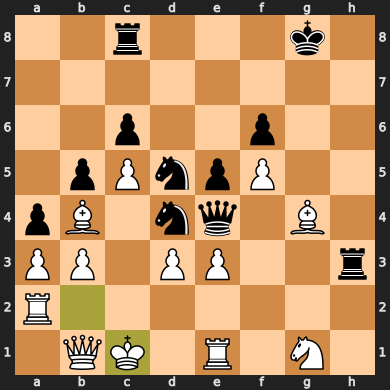

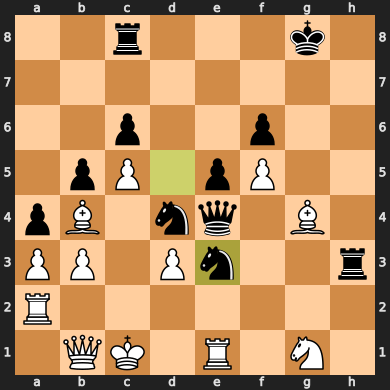

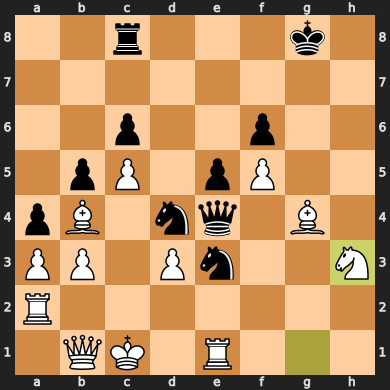

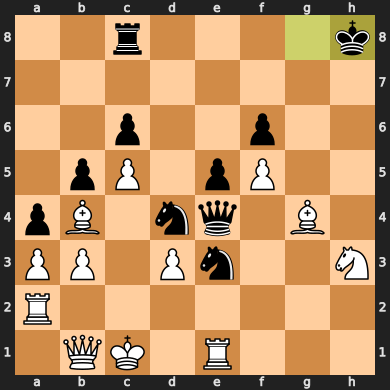

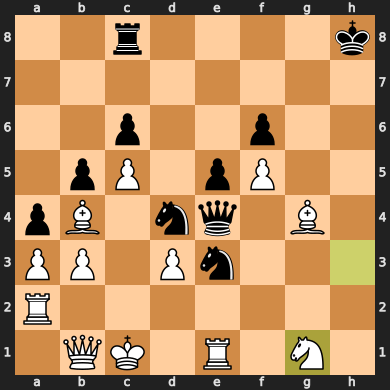

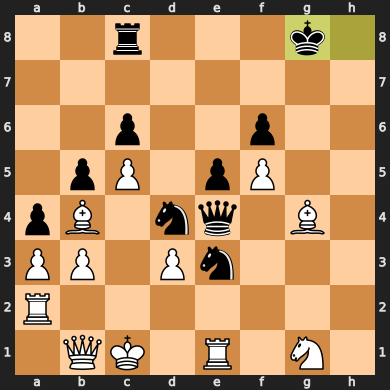

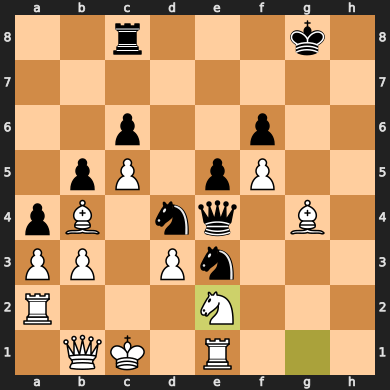

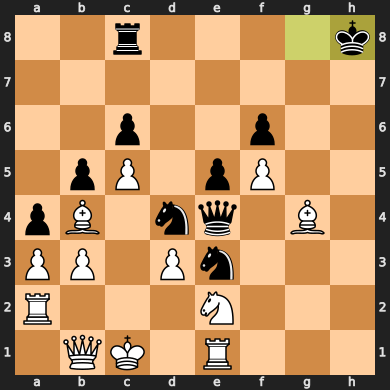

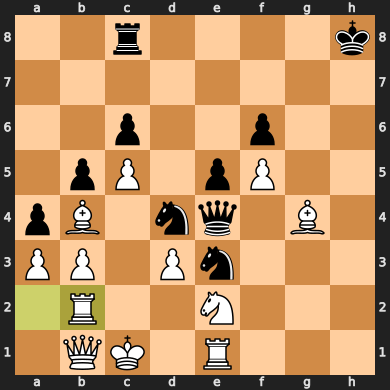

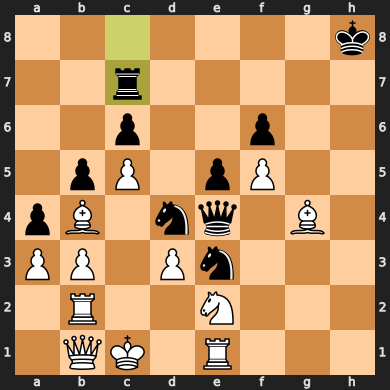

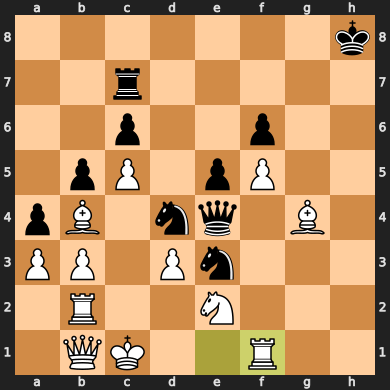

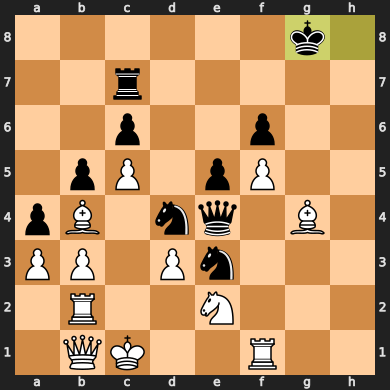

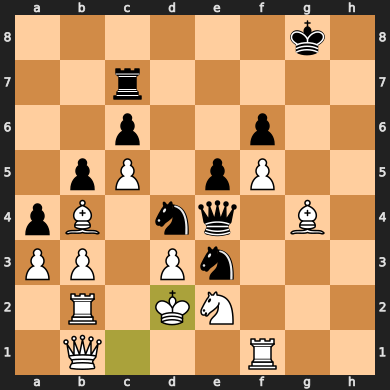

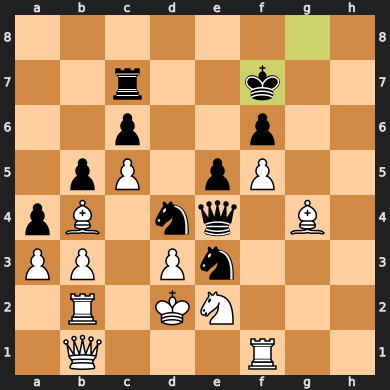

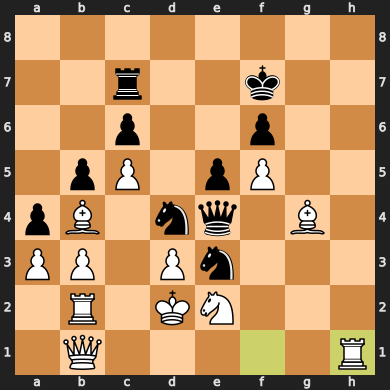

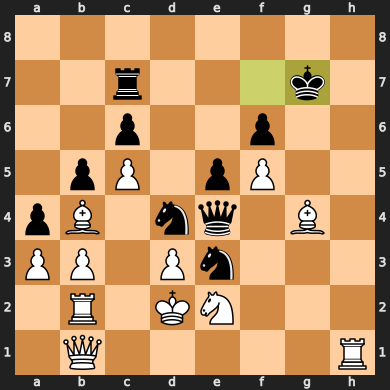

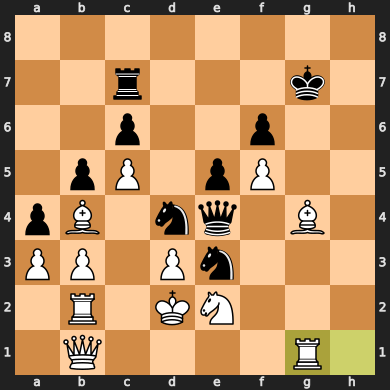

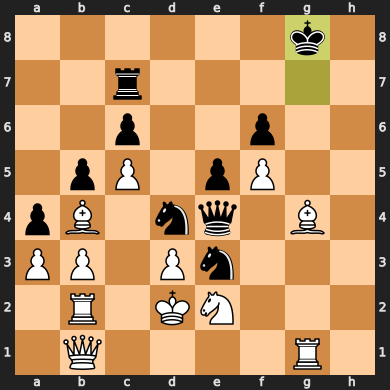

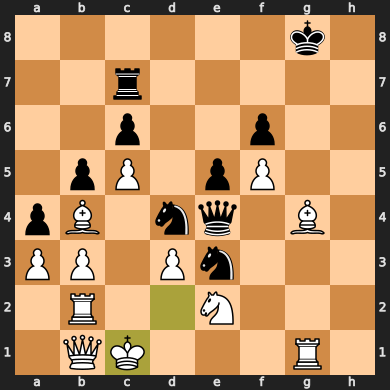

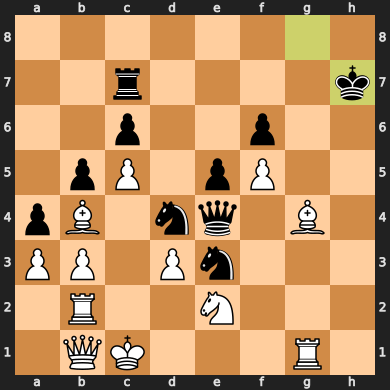

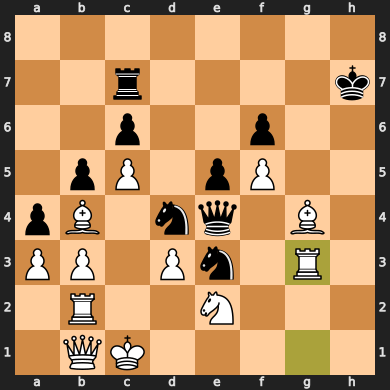

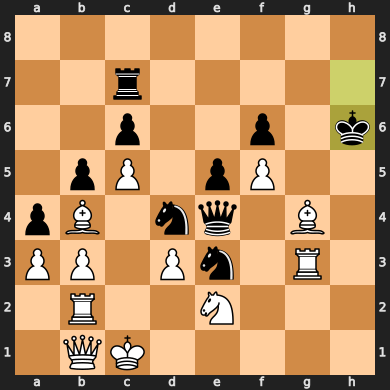

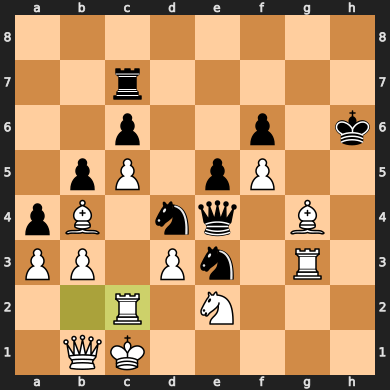

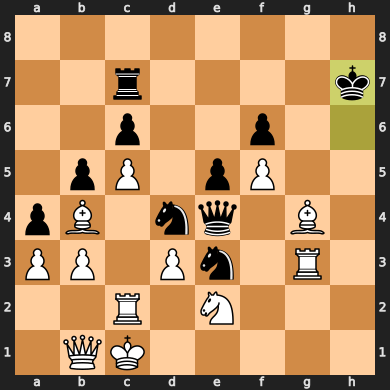

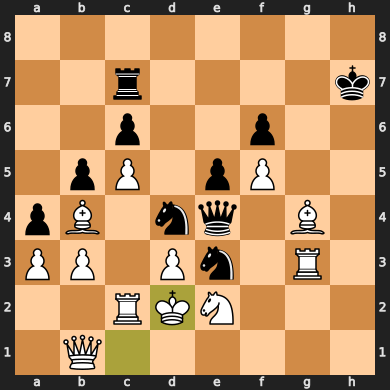

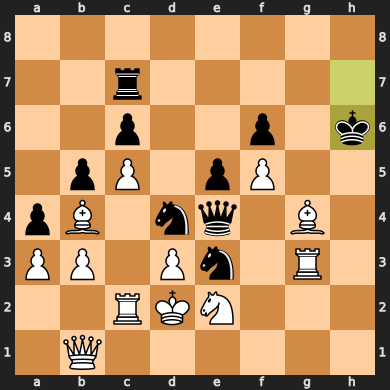

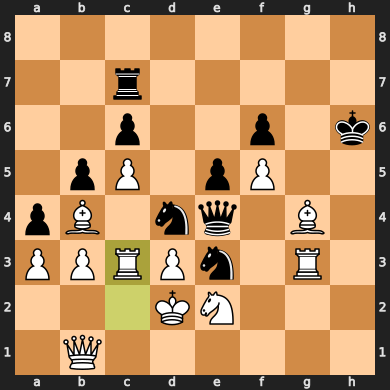

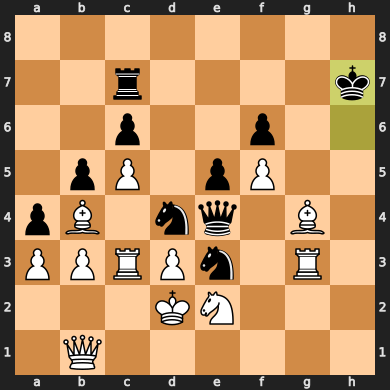

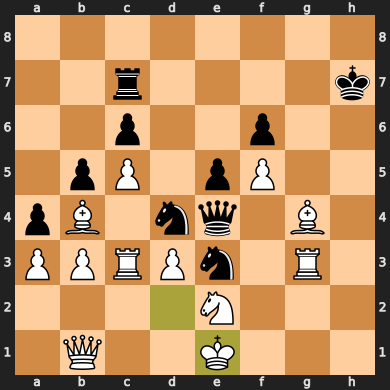

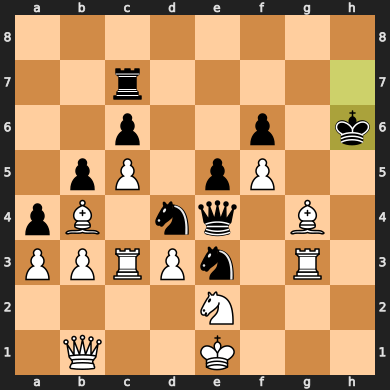

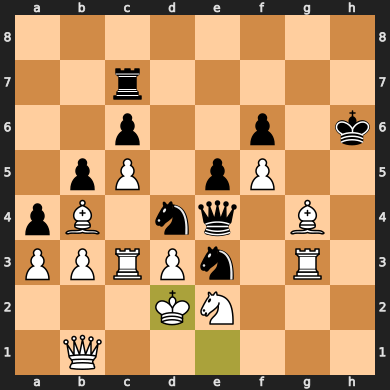

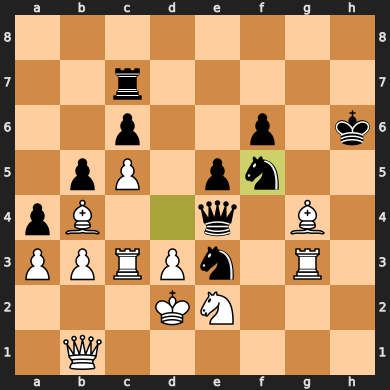

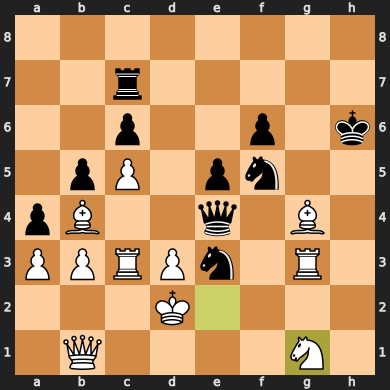

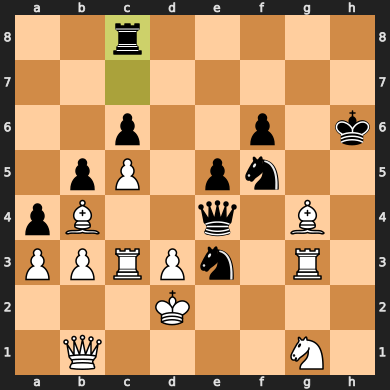

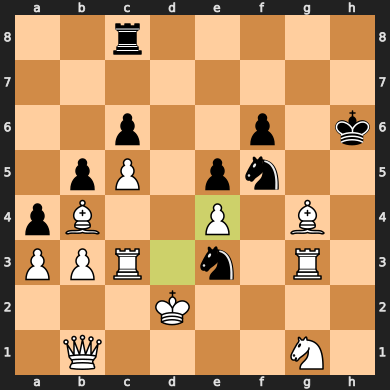

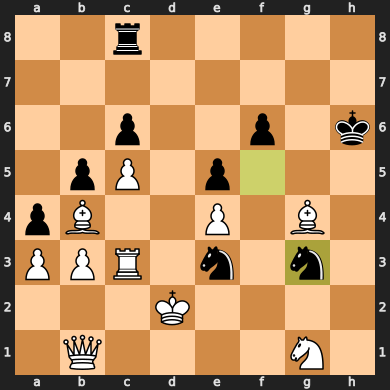

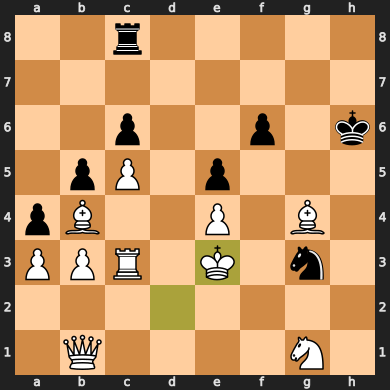

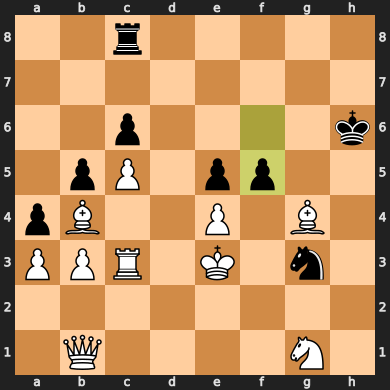

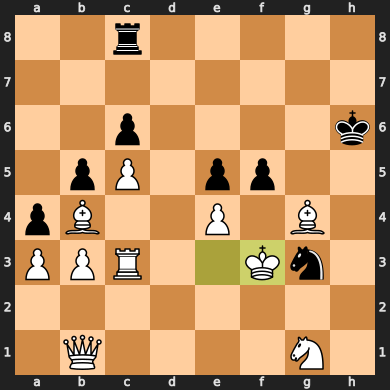

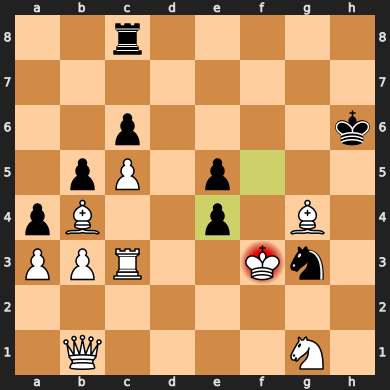

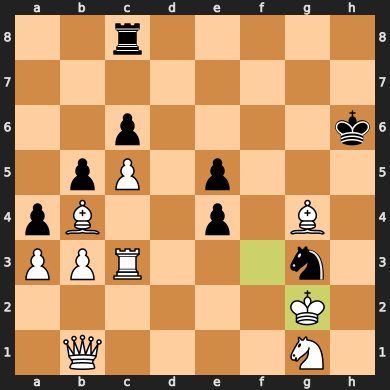

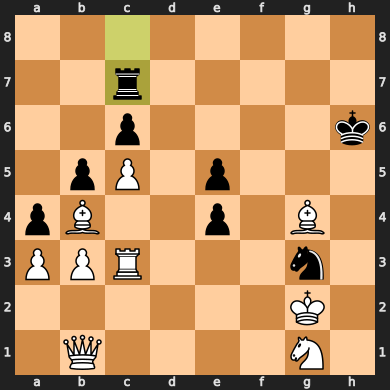

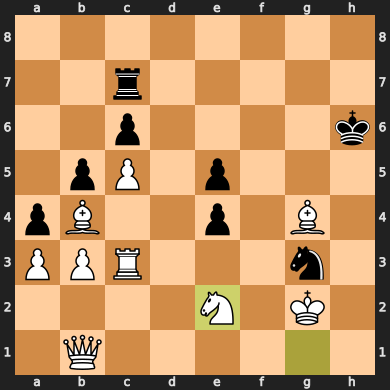

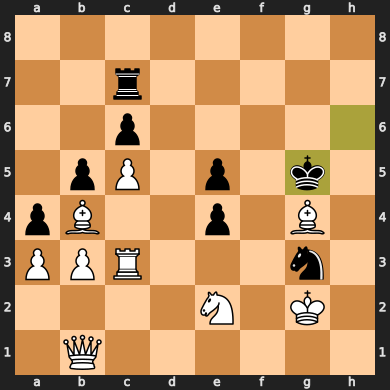

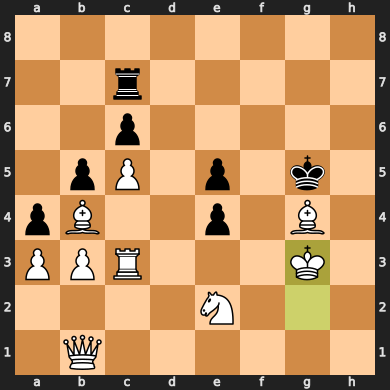

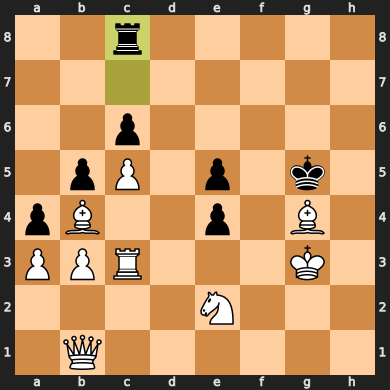

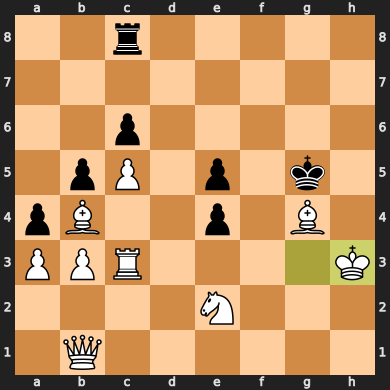

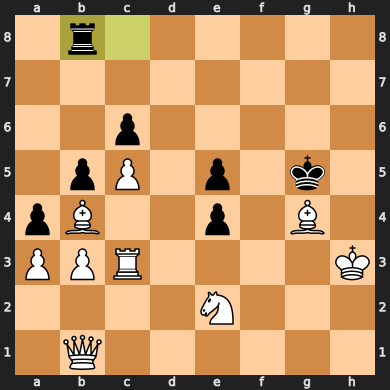

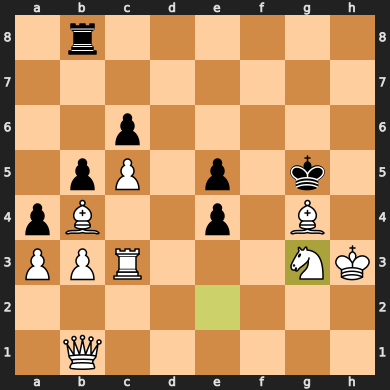

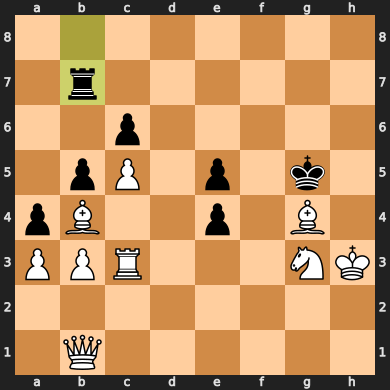

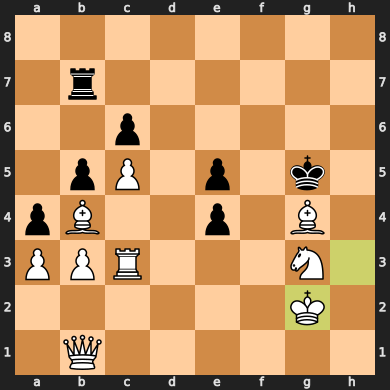

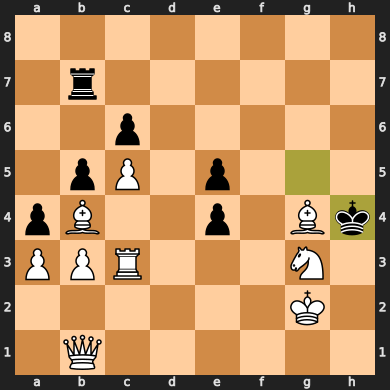

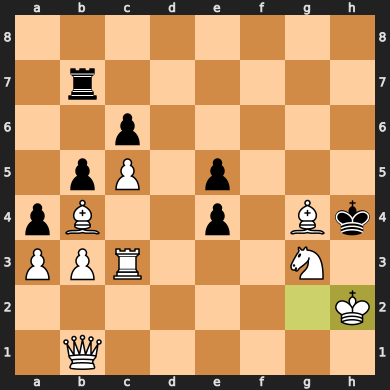

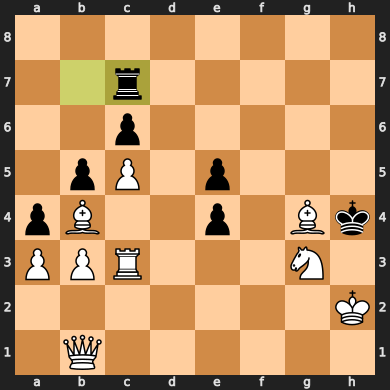

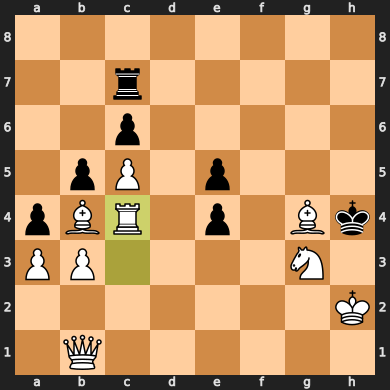

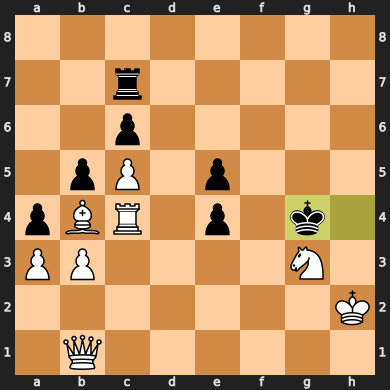

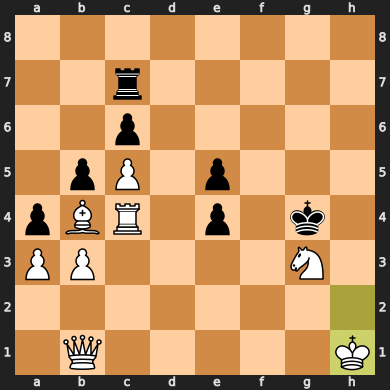

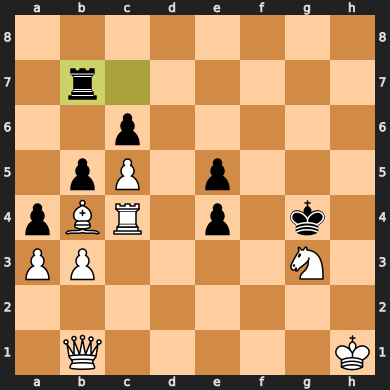

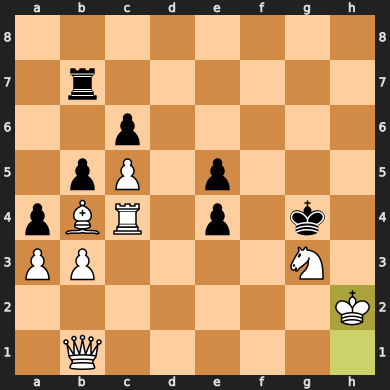

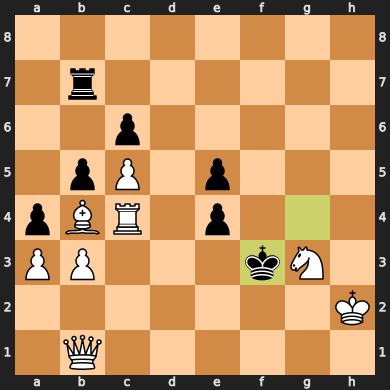

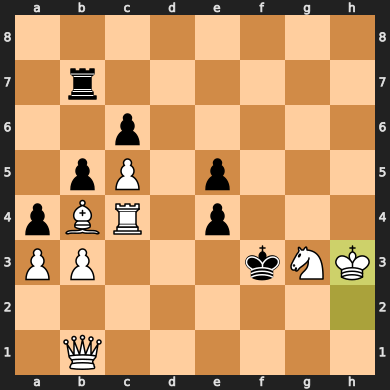

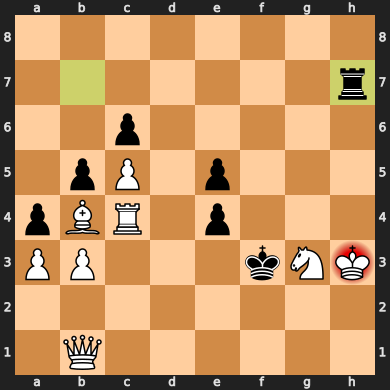

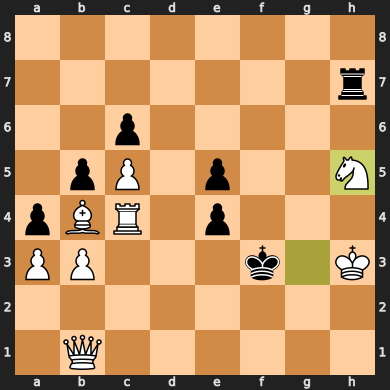

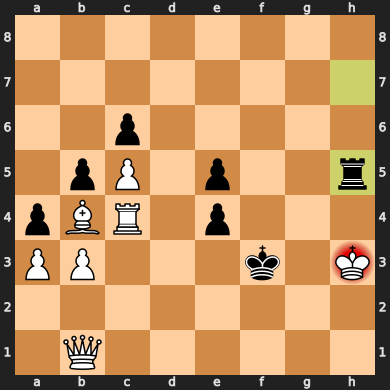

In [40]:
board = selfplayer.test()

In [41]:
board_copy = board.copy()

In [42]:
path = []
while True:
    try:
        move = board.pop()
        path.append(move)
    except:
        break

In [43]:
print(path)

[Move.from_uci('h7h5'), Move.from_uci('g3h5'), Move.from_uci('b7h7'), Move.from_uci('h2h3'), Move.from_uci('g4f3'), Move.from_uci('h1h2'), Move.from_uci('c7b7'), Move.from_uci('h2h1'), Move.from_uci('h4g4'), Move.from_uci('c3c4'), Move.from_uci('b7c7'), Move.from_uci('g2h2'), Move.from_uci('g5h4'), Move.from_uci('h3g2'), Move.from_uci('b8b7'), Move.from_uci('e2g3'), Move.from_uci('c8b8'), Move.from_uci('g3h3'), Move.from_uci('c7c8'), Move.from_uci('g2g3'), Move.from_uci('h6g5'), Move.from_uci('g1e2'), Move.from_uci('c8c7'), Move.from_uci('f3g2'), Move.from_uci('f5e4'), Move.from_uci('e3f3'), Move.from_uci('f6f5'), Move.from_uci('d2e3'), Move.from_uci('f5g3'), Move.from_uci('d3e4'), Move.from_uci('c7c8'), Move.from_uci('e2g1'), Move.from_uci('d4f5'), Move.from_uci('e1d2'), Move.from_uci('h7h6'), Move.from_uci('d2e1'), Move.from_uci('h6h7'), Move.from_uci('c2c3'), Move.from_uci('h7h6'), Move.from_uci('c1d2'), Move.from_uci('h6h7'), Move.from_uci('b2c2'), Move.from_uci('h7h6'), Move.from_

In [45]:
import chess.pgn

In [48]:
game = chess.pgn.Game()
game.headers["Event"] = "Example"
i = len(path)-1
node = game.add_variation(path[i])
i-=1
while i >= 0:
    node = node.add_variation(path[i])
    i-=1
    if i == -1:
        break
    node = node.add_variation(path[i])
    i-=1
# node.comment = "Comment"

print(game)

[Event "Example"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "*"]

1. d3 d5 2. Kd2 Nf6 3. e3 e5 4. c4 Bb4+ 5. Nc3 d4 6. Ne2 dxc3+ 7. Kc2 Nc6 8. a3 a5 9. g3 h5 10. b3 h4 11. g4 Bxg4 12. f3 g5 13. h3 Rh7 14. Bg2 Qd6 15. Rg1 Rh5 16. c5 b6 17. Bf1 Kd8 18. Ra2 Qd5 19. f4 Ke7 20. Bb2 Qe4 21. Qe1 Rb8 22. Ra1 Ke6 23. Qd1 Nd4+ 24. Kb1 b5 25. Kc1 Bxh3 26. Bxc3 a4 27. Bxb4 g4 28. Rh1 Nd5 29. f5+ Kf6 30. Bg2 c6 31. Bxh3 Kg7 32. Ng1 Kh7 33. Kb2 f6 34. Ne2 Kh8 35. Ra2 Kg7 36. Re1 Kh7 37. Bxg4 h3 38. Ng1 Rc8 39. Nxh3 Kg8 40. Ng1 Rh4 41. Qb1 Rh3 42. Kc1 Nxe3 43. Nxh3 Kh8 44. Ng1 Kg8 45. Ne2 Kh8 46. Rb2 Rc7 47. Rf1 Kg8 48. Kd2 Kf7 49. Rh1 Kg7 50. Rg1 Kg8 51. Kc1 Kh7 52. Rg3 Kh6 53. Rc2 Kh7 54. Kd2 Kh6 55. Rc3 Kh7 56. Ke1 Kh6 57. Kd2 Ndxf5 58. Ng1 Rc8 59. dxe4 Nxg3 60. Kxe3 f5 61. Kf3 fxe4+ 62. Kg2 Rc7 63. Ne2 Kg5 64. Kxg3 Rc8 65. Kh3 Rb8 66. Ng3 Rb7 67. Kg2 Kh4 68. Kh2 Rc7 69. Rc4 Kxg4 70. Kh1 Rb7 71. Kh2 Kf3 72. Kh3 Rh7+ 73. Nh5 Rxh5# *


# Play with Human

In [33]:
class ChessGame:
    def __init__(self, agent):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.board = chess.Board()
        self.agent = agent

        # Assuming this exists from previous code

    def display_board(self):
        """Display the current board state."""
        return self.board

    def get_user_move(self):
        """Get a move from the user."""
        while True:
            try:
                move_uci = input("Enter your move (in UCI format, e.g., 'e2e4'), type 'stop' when you want stop the game: ")
                if move_uci == 'stop':
                    return 'stop'
                move = chess.Move.from_uci(move_uci)
                if move in self.board.legal_moves:
                    return move
                else:
                    print("Illegal move. Try again.")
            except ValueError:
                print("Invalid input. Please use UCI format (e.g., 'e2e4')")

    def get_model_move(self): # return str(uci move)
        return self.agent.choose_action(self.board,n_simulations = 200)

    def play_game(self, human_color=chess.WHITE):
        """Play a game between human and AI."""
        import time
        while not self.board.is_game_over():
            display(self.display_board())
            time.sleep(1)
            is_human_turn = (self.board.turn == human_color)

            if is_human_turn:
                move = self.get_user_move()
                if move == 'stop':
                    break

            else:
                print("AI is thinking...")
                move = chess.Move.from_uci(self.get_model_move())
                print(f"AI plays: {move.uci()}")

            self.board.push(move)

        if move == 'stop':
            print('game stop')
            return 0
        # Game over
        display(self.display_board())
        result = self.board.outcome()
        if result.winner is None:
            print("Game drawn!")
        else:
            winner = "White" if result.winner else "Black"
            print(f"{winner} wins!")

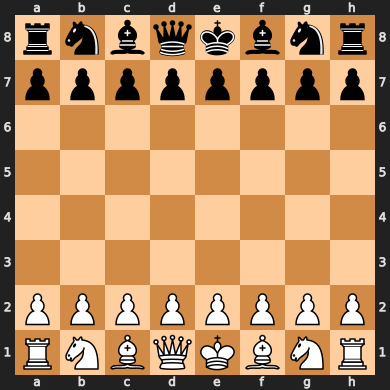

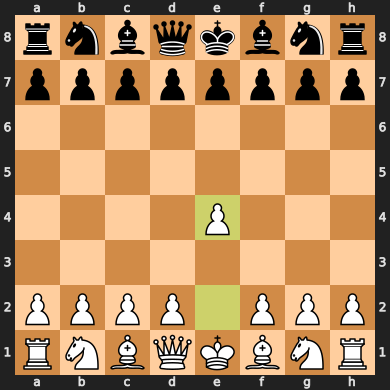

AI is thinking...
AI plays: h7h5


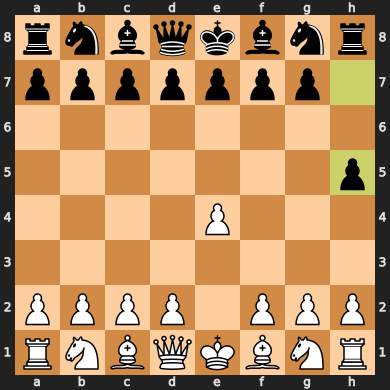

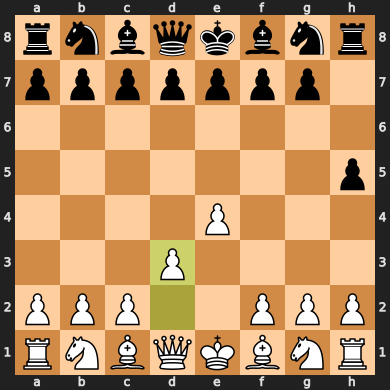

AI is thinking...
AI plays: f7f6


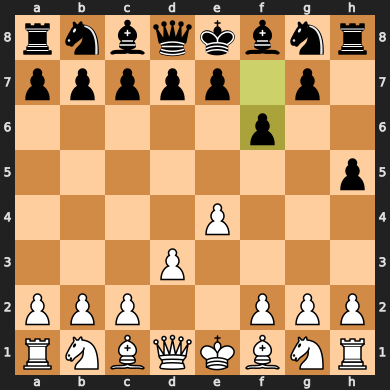

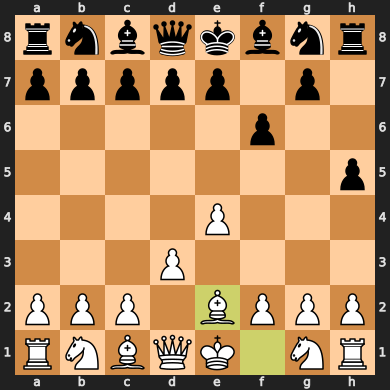

AI is thinking...
AI plays: h8h7


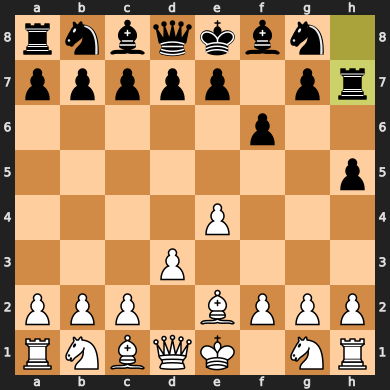

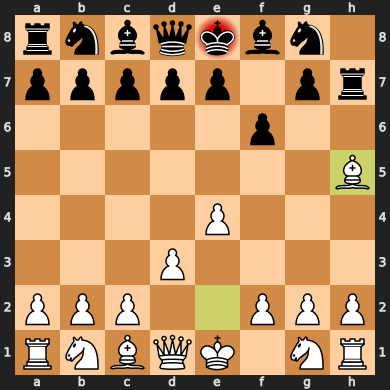

AI is thinking...
AI plays: g7g6


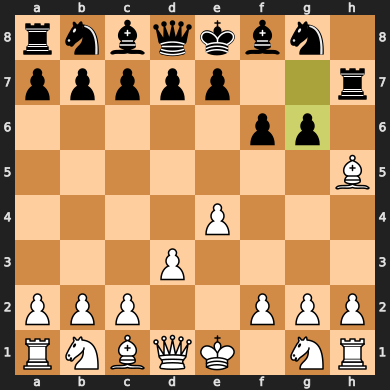

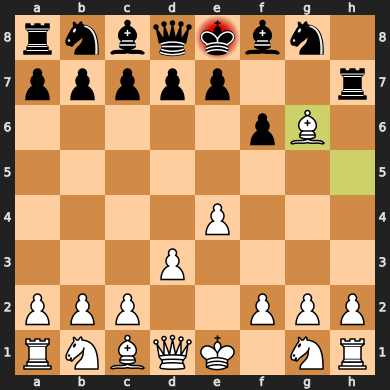

AI is thinking...
AI plays: h7f7


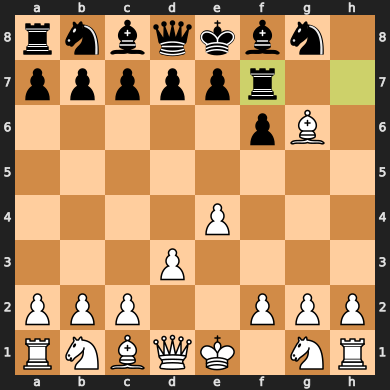

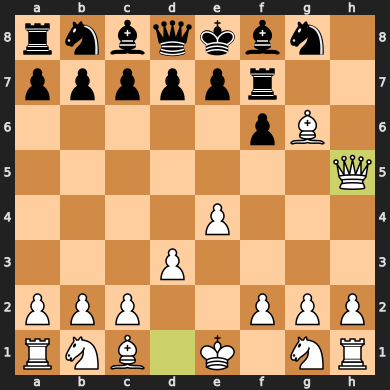

AI is thinking...
AI plays: e7e6


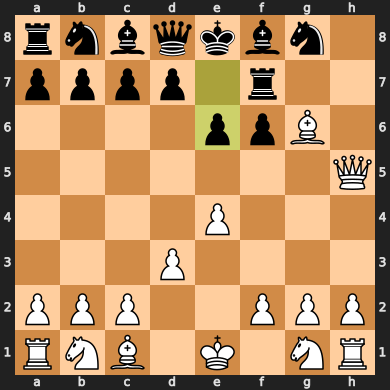

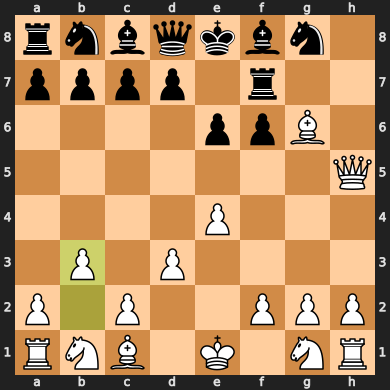

AI is thinking...
AI plays: e8e7


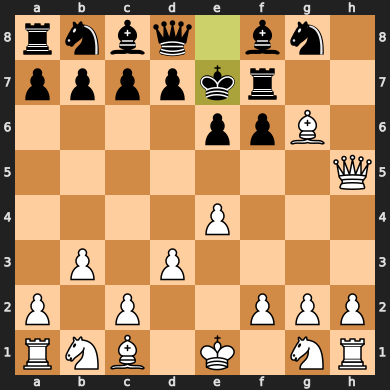

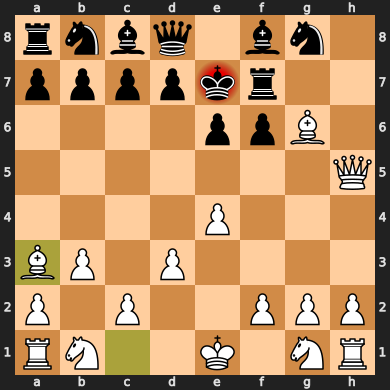

AI is thinking...
AI plays: c7c5


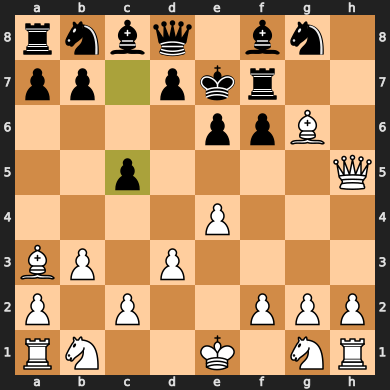

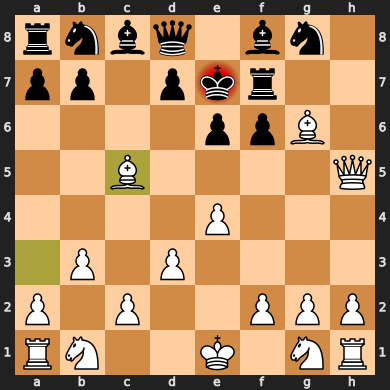

AI is thinking...
AI plays: d7d6


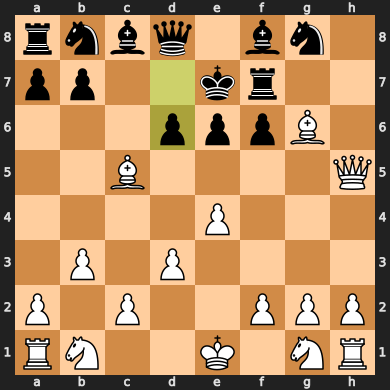

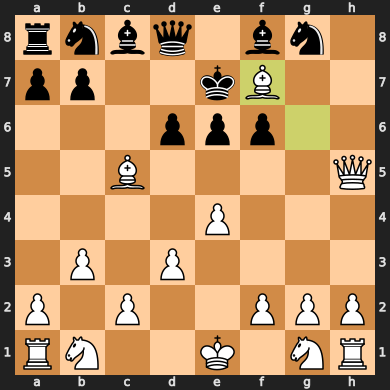

AI is thinking...
AI plays: g8h6


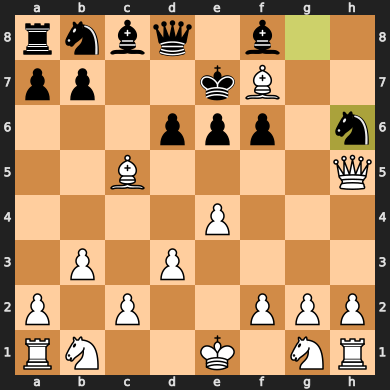

game stop


In [34]:
game = ChessGame(agent=agent)

color = input("Choose your color (white/black): ").lower()
if color in ['white', 'black']:
    human_color = chess.WHITE if color == 'white' else chess.BLACK
    game.play_game(human_color=human_color)


In [51]:
from stockfish import Stockfish
# stockfish = Stockfish(path="stockfish_linux/stockfish-ubuntu-x86-64-avx2",depth=10, parameters={"Skill Level": 50, "UCI_Elo": 3000,"Hash": 4096,"Minimum Thinking Time": 0,"Threads": 20})
# Stockfish(path="stockfish/stockfish_linux/stockfish-ubuntu-x86-64-avx2",depth=5, parameters={"Skill Level": 2, "UCI_Elo": 500,"Hash": 16,"Minimum Thinking Time": 0,"Threads": 1})
class ChessGame:
    def __init__(self, agent):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.board = chess.Board()
        self.agent = agent
        self.stockfish = Stockfish(path="stockfish/stockfish_linux/stockfish-ubuntu-x86-64-avx2",depth=10, parameters={"Skill Level": 10, "UCI_Elo": 1000,"Hash": 16,"Minimum Thinking Time": 0,"Threads": 1})

        # Assuming this exists from previous code

    def display_board(self):
        """Display the current board state."""
        return self.board

    def get_stockfish_move(self):
        """Get a move from the stockfish."""
        self.stockfish.set_fen_position(self.board.fen())
        move = self.stockfish.get_top_moves(1)
        return move[0]['Move']

    def get_model_move(self): # return str(uci move)
        return self.agent.choose_action(self.board,n_simulations = 200)

    def play_game(self, human_color=chess.WHITE):
        """Play a game between human and AI."""
        import time
        while not self.board.is_game_over():
            display(self.display_board())
            time.sleep(1)
            is_human_turn = (self.board.turn == human_color)

            if is_human_turn:
                move = chess.Move.from_uci(self.get_stockfish_move())

            else:
                print("AI is thinking...")
                move = chess.Move.from_uci(self.get_model_move())
                print(f"AI plays: {move.uci()}")

            self.board.push(move)

        # Game over
        display(self.display_board())
        result = self.board.outcome()
        if result.winner is None:
            print("Game drawn!")
        else:
            winner = "White" if result.winner else "Black"
            print(f"{winner} wins!")
        return self.board

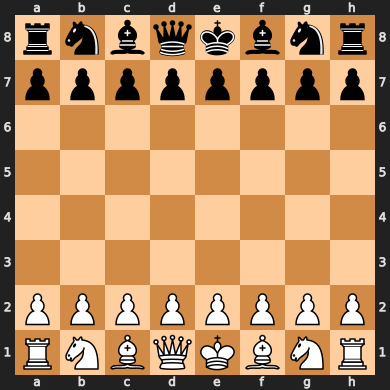

AI is thinking...
AI plays: d2d3


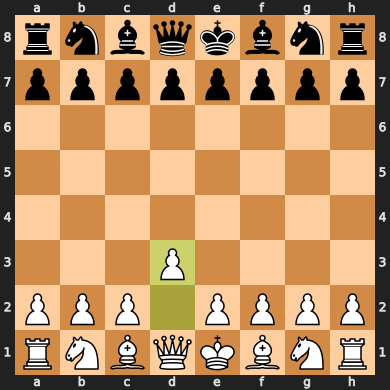

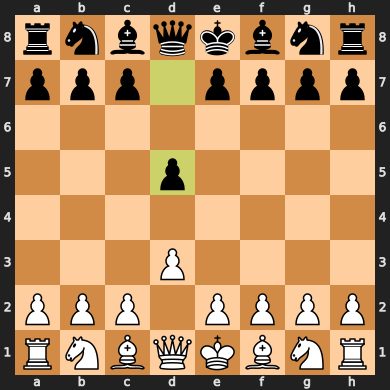

AI is thinking...
AI plays: e1d2


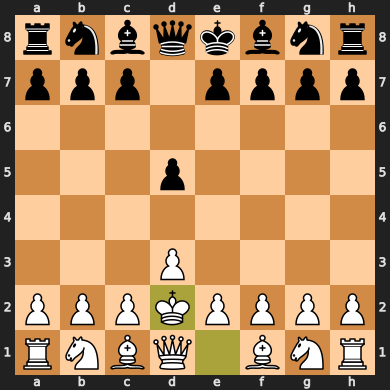

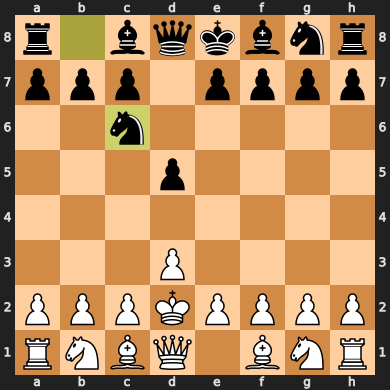

AI is thinking...
AI plays: d3d4


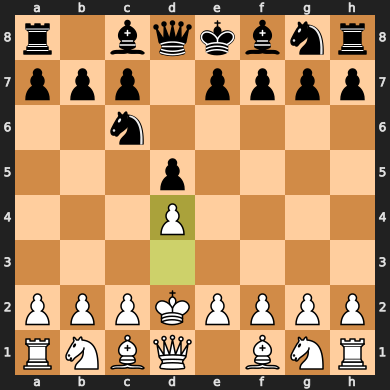

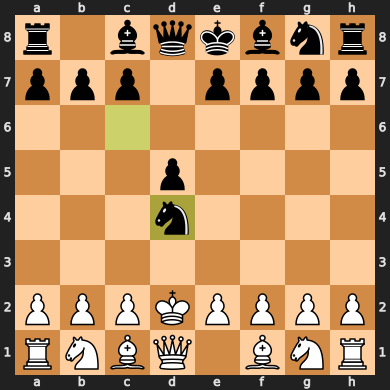

AI is thinking...
AI plays: c2c3


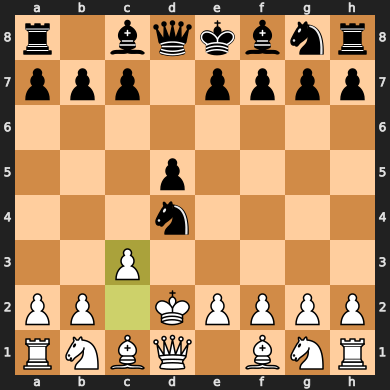

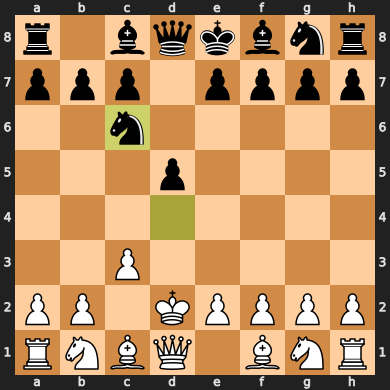

AI is thinking...
AI plays: g1h3


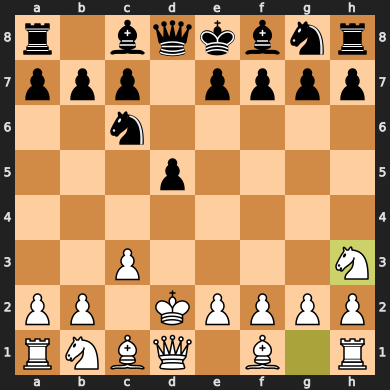

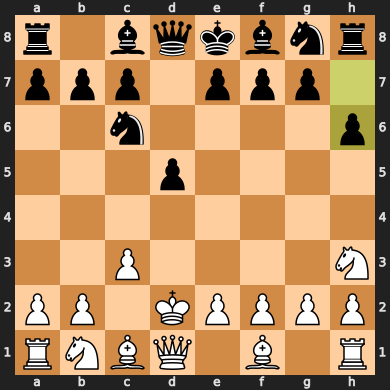

AI is thinking...
AI plays: e2e3


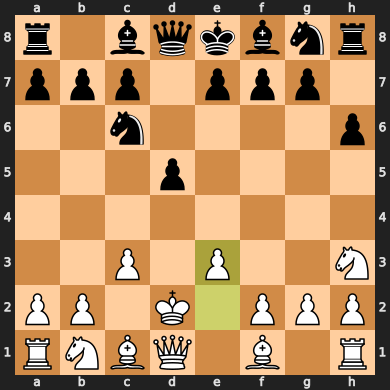

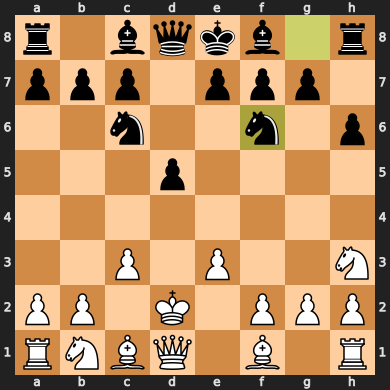

AI is thinking...
AI plays: b1a3


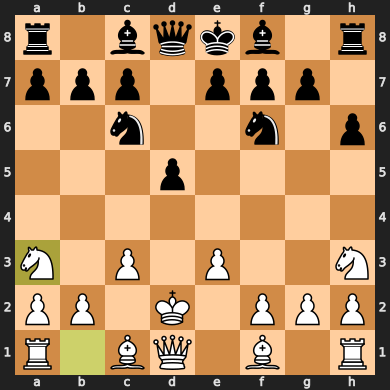

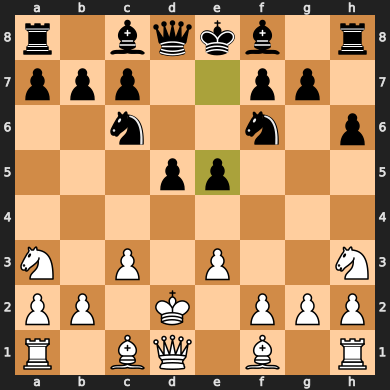

AI is thinking...
AI plays: f1e2


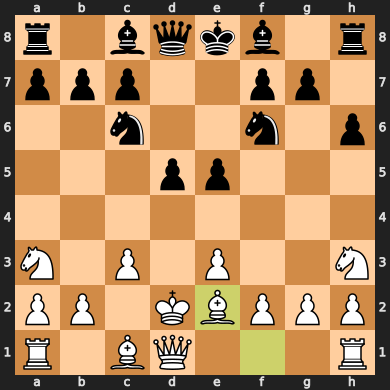

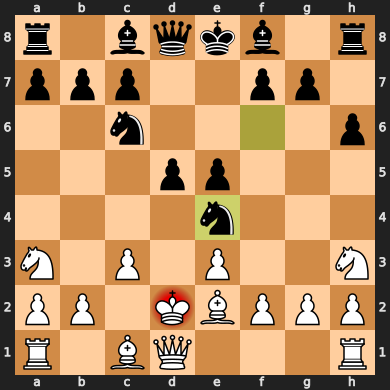

AI is thinking...
AI plays: d2c2


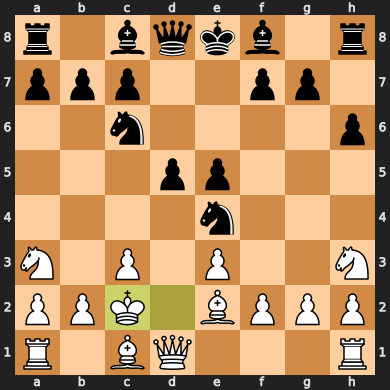

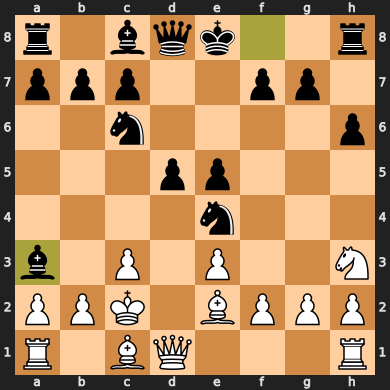

AI is thinking...
AI plays: b2b3


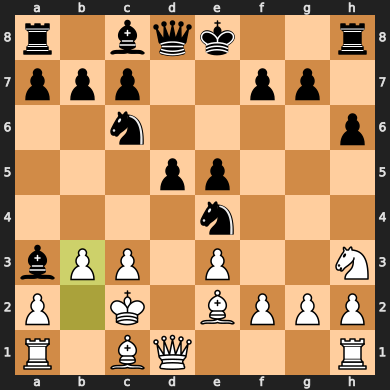

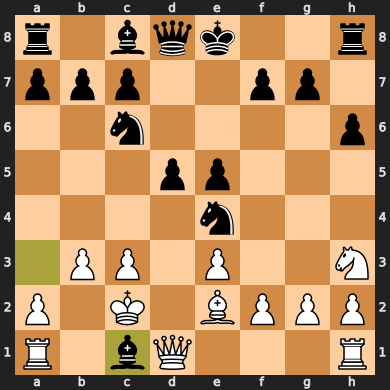

AI is thinking...
AI plays: e2h5


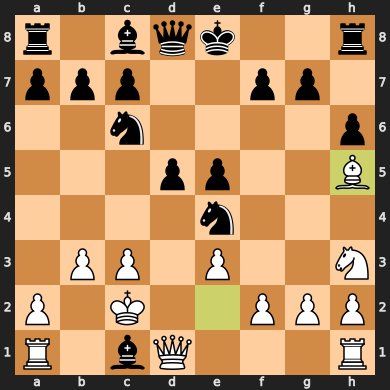

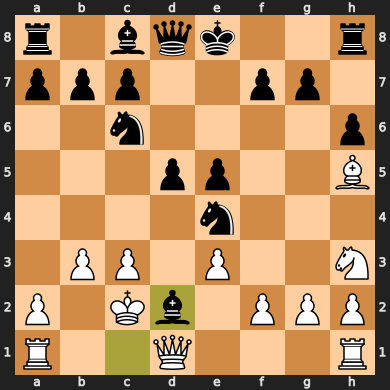

AI is thinking...
AI plays: g2g3


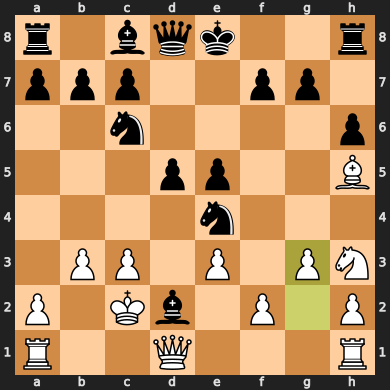

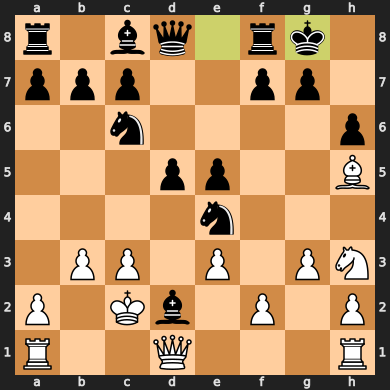

AI is thinking...
AI plays: c2b2


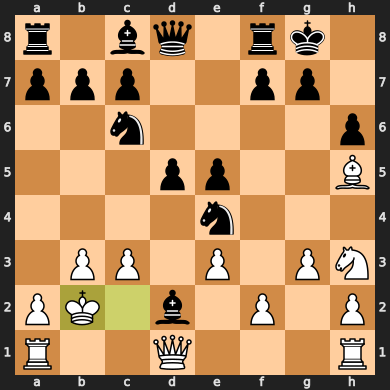

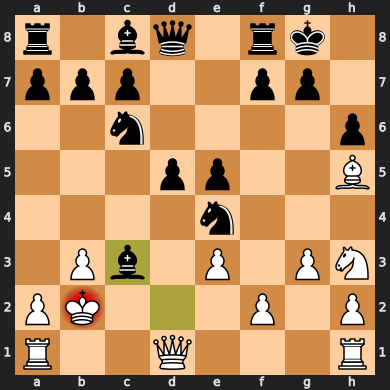

AI is thinking...
AI plays: b2a3


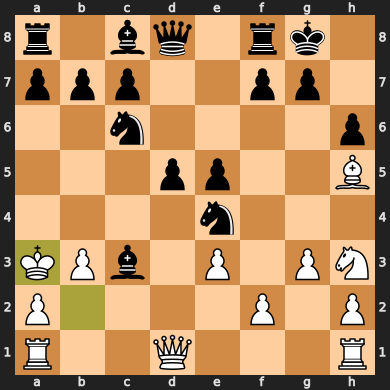

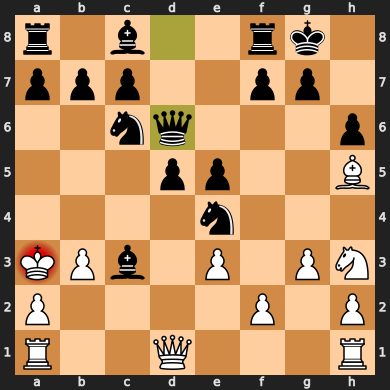

AI is thinking...
AI plays: a3a4


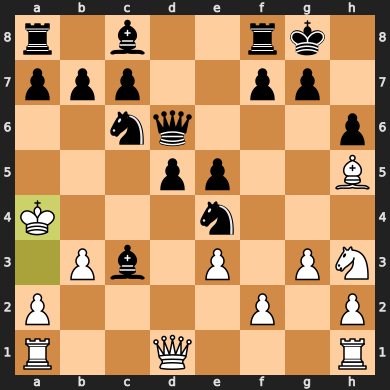

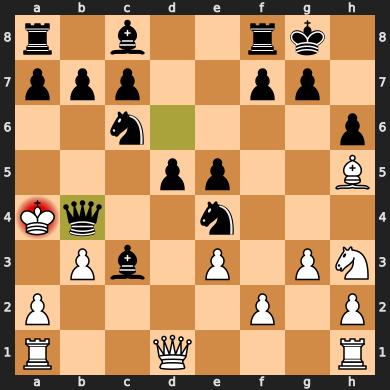

Black wins!


In [53]:
game = ChessGame(agent=agent)

color = input("Choose your color (white/black): ").lower()
if color in ['white', 'black']:
    human_color = chess.WHITE if color == 'white' else chess.BLACK
    board_stochfish = game.play_game(human_color=human_color)